In [2]:
import signal
import tqdm.notebook as tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@markdown A few imports and downloading data
! pip install tqdm

import signal
import tqdm.notebook as tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import openai

In [5]:
import os
os.getcwd()

'/Users/azadi/Documents/NLP/MIPT Lab/AMBIK/ambik_code/knowno_knowno_data'

In [6]:
# Load the 300 scenarios
scenario_info_path = 'metabot-tasks-info.txt'
with open(scenario_info_path, 'r') as f:
  scenario_info_text = f.read()
scenario_info_text = scenario_info_text.split('\n\n')
print('Loaded scenario info from ' + scenario_info_path)

Loaded scenario info from metabot-tasks-info.txt


In [7]:
# Print a scenario
print('Sample scenario:\n')
print(scenario_info_text[0].split('\n',1)[1])  

Sample scenario:

Scene: a Coke, a bottled unsweetened tea, and a Sprite
Task: Bring me a flavored drink.
User intent (object): Coke, bottled unsweetened tea, Sprite
User intent (location): pick-up
Scene objects: Coke, bottled unsweetened tea, Sprite
Task category: creative_multilabel_task


In [8]:
# Load the corresponding prompts for multiple choice generation
mc_gen_prompt_path = 'metabot-mc-gen-prompt.txt'
with open(mc_gen_prompt_path, 'r') as f:
  mc_gen_prompt_all = f.read().split('--0000--')
print('Loaded multiple choice generation prompts from ' + mc_gen_prompt_path)

Loaded multiple choice generation prompts from metabot-mc-gen-prompt.txt


In [9]:
#@title
# Split data into calibration set and test set
calibration_set = []
num_calibration_data = 100
num_test_data = 200
for i in range(num_calibration_data):
  calibration_set.append({
      'info': scenario_info_text[i],
      'mc_gen_prompt': mc_gen_prompt_all[i],
  })
test_set = []
for i in range(num_calibration_data, 300):
  test_set.append({
      'info': scenario_info_text[i],
      'mc_gen_prompt': mc_gen_prompt_all[i],
  })

In [10]:
#@markdown Print an example of task and prompt for MC generation
print('Sample task:\n')
print(calibration_set[0]['info'].split('\n',1)[1])  # remove the printed index
print('\n-------------\nPrompt for MC generation:\n')
print(calibration_set[0]['mc_gen_prompt'])

Sample task:

Scene: a Coke, a bottled unsweetened tea, and a Sprite
Task: Bring me a flavored drink.
User intent (object): Coke, bottled unsweetened tea, Sprite
User intent (location): pick-up
Scene objects: Coke, bottled unsweetened tea, Sprite
Task category: creative_multilabel_task

-------------
Prompt for MC generation:

We: You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange soda, a Pepsi, and an apple.
We: Put that drink in the top drawer.
You:
A) open the top drawer and put the orange soda in it
B) open the bottom drawer and put the Pepsi in it
C) open the bottom drawer and put the orange soda in it
D) open the top drawer and put the Pepsi in it

We: On the counter, there is an energy bar, a banana, and a microwave.
We: Put the snack next to the microwave.
You:
A) pick up the energy bar and put 

In [6]:
from openai import OpenAI
client = OpenAI(api_key=open_api_key)

In [63]:
import pandas as pd
calib = pd.DataFrame(calibration_set)
calib.to_csv('calib.csv')

In [64]:
import pandas as pd
test = pd.DataFrame(test_set)
test.to_csv('test.csv')

In [8]:
import pandas as pd
with open('knowno_knowno_data/calib.csv') as file:
    calibration_set = pd.read_csv(file)

with open('knowno_knowno_data/test.csv') as file:
    test_set = pd.read_csv(file)

In [9]:
calibration_set = calibration_set.to_dict(orient='records')
test_set = test_set.to_dict(orient='records')

In [10]:
calibration_set[0]

{'Unnamed: 0': 0,
 'info': '0\nScene: a Coke, a bottled unsweetened tea, and a Sprite\nTask: Bring me a flavored drink.\nUser intent (object): Coke, bottled unsweetened tea, Sprite\nUser intent (location): pick-up\nScene objects: Coke, bottled unsweetened tea, Sprite\nTask category: creative_multilabel_task',
 'mc_gen_prompt': 'We: You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.\n\nWe: On the counter, there is an orange soda, a Pepsi, and an apple.\nWe: Put that drink in the top drawer.\nYou:\nA) open the top drawer and put the orange soda in it\nB) open the bottom drawer and put the Pepsi in it\nC) open the bottom drawer and put the orange soda in it\nD) open the top drawer and put the Pepsi in it\n\nWe: On the counter, there is an energy bar, a banana, and a microwave.\nWe: Put the snack next to the microwave.\nYou:\nA) pick up the energ

In [11]:
target_success = 0.8  #@param {type: "number"} {form-width: "10%"}
epsilon = 1-target_success
print('Epsilon:', epsilon)

Epsilon: 0.19999999999999996


In [12]:
def process_mc_raw(mc_raw, add_mc='an option not listed here'):
  mc_all = mc_raw.split('\n')
  mc_processed_all = []
  for mc in mc_all:
      mc = mc.strip()  # sometimes there is leading space
      # skip nonsense
      if len(mc) < 5 or mc[0] not in [
          'a', 'b', 'c', 'd', 'A', 'B', 'C', 'D', '1', '2', '3', '4'
      ]:
          continue
      mc = mc[2:]  # remove a), b), ...
      mc = mc.strip().lower().split('.')[0]
      mc_processed_all.append(mc)
  if len(mc_processed_all) < 4:
      pass
      #raise 'Cannot extract four options from the raw output.'
  # Check if any repeated option - use do nothing as substitue
  mc_processed_all = list(set(mc_processed_all))
  if len(mc_processed_all) < 4:
      num_need = 4 - len(mc_processed_all)
      for _ in range(num_need):
          mc_processed_all.append('do nothing')
  prefix_all = ['A) ', 'B) ', 'C) ', 'D) ']
  if add_mc is not None:
      mc_processed_all.append(add_mc)
      prefix_all.append('E) ')
  random.shuffle(mc_processed_all)
  mc_prompt = ''
  for mc_ind, (prefix, mc) in enumerate(zip(prefix_all, mc_processed_all)):
      mc_prompt += prefix + mc
      if mc_ind < len(mc_processed_all) - 1:
          mc_prompt += '\n'
  add_mc_prefix = prefix_all[mc_processed_all.index(add_mc)][0]
  return mc_prompt, mc_processed_all, add_mc_prefix

In [13]:
import random

for dataset in test_set:
    mc_gen_raw = dataset['mc_gen_raw']
    mc_gen_prompt = dataset['mc_gen_prompt']
    mc_gen_raw = mc_gen_raw.strip()
    mc_gen_full, mc_gen_all, add_mc_prefix = process_mc_raw(mc_gen_raw)
    dataset['mc_gen_full'] = mc_gen_full
    dataset['mc_gen_all'] = mc_gen_all
    dataset['add_mc_prefix'] = add_mc_prefix

    # get the part of the current scenario from the previous prompt
    cur_scenario_prompt = mc_gen_prompt.split('\n\n')[-1].strip()

    mc_score_background_prompt = """
    You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.
    """.strip()
    mc_score_prompt = mc_score_background_prompt + '\n\n' + cur_scenario_prompt + '\n' 
    mc_score_prompt += mc_gen_full
    mc_score_prompt += "\nWe: Which option is correct? Answer with a single letter."
    mc_score_prompt += "\nYou:"
    dataset['mc_score_prompt'] = mc_score_prompt


for dataset in calibration_set:
    mc_gen_raw = dataset['mc_gen_raw']
    mc_gen_prompt = dataset['mc_gen_prompt']
    mc_gen_raw = mc_gen_raw.strip()
    mc_gen_full, mc_gen_all, add_mc_prefix = process_mc_raw(mc_gen_raw)
    dataset['mc_gen_full'] = mc_gen_full
    dataset['mc_gen_all'] = mc_gen_all
    dataset['add_mc_prefix'] = add_mc_prefix

    # get the part of the current scenario from the previous prompt
    cur_scenario_prompt = mc_gen_prompt.split('\n\n')[-1].strip()

    mc_score_background_prompt = """
    You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.
    """.strip()
    mc_score_prompt = mc_score_background_prompt + '\n\n' + cur_scenario_prompt + '\n' 
    mc_score_prompt += mc_gen_full
    mc_score_prompt += "\nWe: Which option is correct? Answer with a single letter."
    mc_score_prompt += "\nYou:"
    dataset['mc_score_prompt'] = mc_score_prompt


In [14]:
directions = ['next', 'left', 'right', 'in', 'near', 'beside']

for dataset in [calibration_set, test_set]:
  for data_ind, data in enumerate(dataset):
    print(data)
    true_options = []
    info = data['info']
    mc_gen_all = data['mc_gen_all']

    # extract the line started with user intent (object) from info
    info = info.split('\n',1)[1]  # remove index
    true_obj = info.split('User intent (object): ')[1].split('\n')[0].lower()
    true_obj = true_obj.split(',')
    true_obj = [obj.strip() for obj in true_obj]
    true_target_loc = info.split('User intent (location): ')[1].split('\n')[0].lower()
    print(true_obj, '   ', true_target_loc)

    # go through all mc
    token_all = ['A', 'B', 'C', 'D', 'E']
    for mc_ind, mc in enumerate(mc_gen_all):
      if 'not listed here' in mc or 'do nothing' in mc: continue

      # corner case: if there is only one sponge, shrink true_obj to only sponge
      scene_obj = info.split('Scene objects:')[1].split('\n')[0].split(', ')
      scene_obj = [obj.strip().lower() for obj in scene_obj]
      for i in range(len(true_obj)):
        if not ('clean sponge' in scene_obj and 'dirty sponge with food residue' in scene_obj) \
          and 'sponge' in true_obj[i]:
          true_obj[i] = 'sponge'

      # corner case: mc has both clean and dirty
      if 'clean' in mc and 'dirty' in mc: continue

      # corner case: orange and orange soda - not dealt with

      if true_target_loc == 'pick-up':
        # check if more than one scene object in the mc
        num_obj_in_mc = 0
        for obj in scene_obj:
          if obj in mc.lower(): num_obj_in_mc += 1
        if num_obj_in_mc > 1: continue

        for obj in true_obj:
          if obj in mc and 'drawer' not in mc and 'bin' not in mc and \
            'microwave' not in mc and 'cooktop' not in mc:
            true_options.append(token_all[mc_ind])
      elif 'drawer' in true_target_loc:
        for obj in true_obj:
          if obj in mc and true_target_loc in mc:
            true_options.append(token_all[mc_ind])
      elif 'recycling' in true_target_loc or 'landfill' in true_target_loc \
        or 'compost' in true_target_loc or 'microwave' in true_target_loc \
        or 'cooktop' in true_target_loc:
        for obj in true_obj:
          if obj in mc and true_target_loc in mc:
            true_options.append(token_all[mc_ind])
      else: # target location is an object
        if 'and' in mc:
          mc_obj_pick_up_phrase = mc.split('and')[0]
          mc_obj_place_phrase = mc.split('and')[1]
          for obj in true_obj:
            if obj in mc_obj_pick_up_phrase and true_target_loc in mc_obj_place_phrase:
              true_options.append(token_all[mc_ind])
        elif 'put' in mc:
          sep = False
          for dir in directions:
            if dir in mc:
              sep = dir
          if type(sep) == str:
            mc_obj_pick_up_phrase = mc.split(sep)[0]
            mc_obj_place_phrase = mc.split(sep)[1]
            for obj in true_obj:
              if obj in mc_obj_pick_up_phrase and true_target_loc in mc_obj_place_phrase:
                true_options.append(token_all[mc_ind])

    # if none correct
    if len(true_options) == 0:
      true_options = [data['add_mc_prefix']]

    # save
    dataset[data_ind]['true_options'] = true_options

{'Unnamed: 0': 0, 'info': '0\nScene: a Coke, a bottled unsweetened tea, and a Sprite\nTask: Bring me a flavored drink.\nUser intent (object): Coke, bottled unsweetened tea, Sprite\nUser intent (location): pick-up\nScene objects: Coke, bottled unsweetened tea, Sprite\nTask category: creative_multilabel_task', 'mc_gen_prompt': 'We: You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.\n\nWe: On the counter, there is an orange soda, a Pepsi, and an apple.\nWe: Put that drink in the top drawer.\nYou:\nA) open the top drawer and put the orange soda in it\nB) open the bottom drawer and put the Pepsi in it\nC) open the bottom drawer and put the orange soda in it\nD) open the top drawer and put the Pepsi in it\n\nWe: On the counter, there is an energy bar, a banana, and a microwave.\nWe: Put the snack next to the microwave.\nYou:\nA) pick up the energy 

In [15]:
print(calibration_set[0].keys())

dict_keys(['Unnamed: 0', 'info', 'mc_gen_prompt', 'mc_gen_raw', 'mc_gen_full', 'mc_gen_all', 'add_mc_prefix', 'mc_score_prompt', 'true_options'])


генерим варианты

In [22]:
import sys
import tqdm

sys.path.append(".")
sys.path.append("./utils")
from llm import LLM
from parse_config import parse_args, parse_config

from llm import LLM

configs = parse_config("./configs/knowno.yaml" , use_args=True)
answering = configs['answering']['generation_kwargs']

llm = LLM('gpt-3.5-turbo', answering)

for i, dataset in enumerate([calibration_set, test_set]):
  if i == 0:
    print('Running calibration set...printing first five results...')
  else:
    print('Running test set...printing first five results...')
  for i in tqdm.tqdm(range(len(dataset))):
    prompt = dataset[i]['mc_score_prompt']
    print(prompt)

    # call LLM API

    text, logits = llm.generate(prompt, return_logits=True)
    top_logprobs_full = logits[0][0]
    filtered_logits = llm.filter_logits(logits[-1][0], words=["A", "B", "C", "D", 'a', 'b', 'c', 'd', '1', '2', '3', '4'])
    print(filtered_logits)

    #print(top_logprobs_full)
    #]["top_logprobs"]
    top_tokens = [token.strip() for token in top_logprobs_full.keys()]
    top_logprobs = [value for value in top_logprobs_full.values()]
    print(top_tokens, top_logprobs)
    #if i < 5:
     # print(top_tokens, top_logprobs)
    dataset[i]['top_logprobs_full'] = top_logprobs_full
    dataset[i]['top_tokens'] = top_tokens
    dataset[i]['top_logprobs'] = top_logprobs

{'examples_generation': {'model': 'gpt-3.5-turbo', 'generation_kwargs': {'max_tokens': 256, 'stop': ['We:'], 'logprobs': False, 'logit_bias': {}}}, 'answering': {'model': 'gpt3.5-turbo', 'generation_kwargs': {'max_tokens': 1, 'logprobs': True, 'top_logprobs': 5, 'stop': 'None', 'logit_bias': {317: 100.0, 347: 100.0, 327: 100.0, 360: 100.0, 412: 100.0, '317': 100.0, '347': 100.0, '327': 100.0, '360': 100.0, '412': 100.0}}}}
Running calibration set...printing first five results...


  0%|          | 0/100 [00:00<?, ?it/s]

You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bottled unsweetened tea, and a Sprite. 
We: Bring me a flavored drink.
You:
A) pick up the sprite
B) pick up the coke
C) pick up the bottled unsweetened tea
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  1%|          | 1/100 [00:00<01:17,  1.27it/s]

{'C': 0.9543003922874688, 'A': 0.03724355003822855, 'D': 0.006434269253605729, 'B': 0.002021788420696965}
['C', 'A', 'D', 'B', 'C'] [-0.047441278, -3.290941, -5.0467815, -6.2044373, -7.657976]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Coke, and a RedBull. 
We: Bring me that caffeinated drink.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the redbull
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  2%|▏         | 2/100 [00:01<01:07,  1.46it/s]

{'D': 0.9994792665202116, 'C': 0.0005207334797883721}
['D', 'D', 'C', 'Option', 'E'] [-0.0027739669, -6.2046514, -7.5625253, -8.780572, -11.288308]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, an orange, and an apple. 
We: It is too sweet. Can you dispose of it?
You:
A) pick up the orange and put it in the compost bin
B) pick up the orange and put it in the landfill bin
C) pick up the orange soda and put it in the landfill bin
D) pick up the apple and put it in the recycling bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


  3%|▎         | 3/100 [00:01<00:58,  1.65it/s]

{'A': 0.7828728016059411, 'C': 0.14749244331991487, 'B': 0.06939478653647084, 'D': 0.0002399685376732037}
['A', 'C', 'B', 'E', 'D'] [-0.24852431, -1.9177176, -2.6716828, -5.6807485, -8.338742]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, an energy bar, and a Coke. 
We: Put that Coke in the bottom drawer.
You:
A) do nothing
B) open the bottom drawer and put the coke in it
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  4%|▍         | 4/100 [00:02<00:55,  1.72it/s]

{'B': 0.9999689057580936, 'D': 3.10942419063961e-05}
['B', 'B', 'D', 'Option', 'E'] [-0.0001311911, -9.926975, -10.378588, -10.515337, -12.058657]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bottled unsweetened tea, and a bottled water. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) pick up the redbull and put it in the recycling bin
B) pick up the redbull and put it in the landfill bin
C) an option not listed here
D) pick up the bottled water and put it in the landfill bin
E) pick up the unsweetened tea and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


  5%|▌         | 5/100 [00:02<00:53,  1.79it/s]

{'B': 0.6984929545043598, 'C': 0.22613642374428483, 'A': 0.07229035819971764, 'D': 0.0030802635516376598}
['B', 'C', 'E', 'A', 'D'] [-0.46462747, -1.5924141, -2.302089, -2.7328618, -5.8885374]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bag of kettle chips, and a bag of rice chips. 
We: I ate it already. Can you dispose of it?
You:
A) pick up the kettle chips and put it in the landfill bin
B) pick up the rice chips and put it in the recycling bin
C) pick up the orange and put it in the landfill bin
D) pick up the orange and put it in the compost bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


  6%|▌         | 6/100 [00:03<00:56,  1.67it/s]

{'C': 0.5176740691086869, 'D': 0.24767215946878496, 'A': 0.17964639274492258, 'B': 0.05500737867760566}
['C', 'D', 'E', 'A', 'B'] [-0.8509675, -1.5882074, -1.7479974, -1.9093229, -3.092846]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, an apple, and an orange. 
We: Bring me that fruit.
You:
A) pick up the orange
B) pick up the apple
C) pick up the energy bar
D) an option not listed here
E) pick up both the apple and the orange
We: Which option is correct? Answer with a single letter.
You:


  7%|▋         | 7/100 [00:04<00:53,  1.73it/s]

{'B': 0.859271810704893, 'C': 0.07988647775433522, 'A': 0.0608417115407717}
['E', 'B', 'E', 'C', 'A'] [-0.0020823358, -6.5170283, -8.462987, -8.892507, -9.164838]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a bottled unsweetened tea, and a clean sponge. 
We: Bring me the sponge.
You:
A) do nothing
B) an option not listed here
C) pick up the dirty sponge with food residue
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  8%|▊         | 8/100 [00:04<00:51,  1.78it/s]

{'C': 0.9998746620262671, 'A': 9.161831044900414e-05, 'B': 3.37196632839253e-05}
['C', 'C', 'A', 'B', 'Option'] [-0.0005779353, -7.7663116, -9.298332, -10.297882, -12.0431595]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bottled unsweetened tea, and a Coke. 
We: Put Coke beside the bottle.
You:
A) do nothing
B) pick up the bottled water and put it beside the coke
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  9%|▉         | 9/100 [00:05<00:51,  1.77it/s]

{'B': 0.9939107939404989, 'C': 0.0050708297860691, 'A': 0.0010183762734318513}
['B', 'C', 'A', 'B', 'Option'] [-0.006404012, -5.284547, -6.889842, -8.971004, -9.3851385]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bottled unsweetened tea, and a Pepsi. 
We: Bring me that cola.
You:
A) pick up the coke
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 10%|█         | 10/100 [00:05<00:48,  1.86it/s]

{'A': 0.9994163489401984, 'D': 0.0005836510598015144}
['A', 'A', 'D', 'Option', 'I'] [-0.0018429674, -6.972531, -7.4474664, -8.529081, -10.592651]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a metal bowl, a plastic bowl, and an portable induction cooktop. 
We: Place the bowl on the cooktop, please.
You:
A) do nothing
B) pick up the metal bowl and place it on the cooktop
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 11%|█         | 11/100 [00:06<00:48,  1.85it/s]

{'B': 0.9999748820521027, 'A': 2.5117947897409345e-05}
['B', 'E', 'B', 'Option', 'A'] [-0.00041720658, -8.709626, -9.122607, -9.457767, -10.59232]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of jalapeno chips, and a bag of multigrain chips. 
We: Bring me that chips.
You:
A) an option not listed here
B) do nothing
C) pick up the bag of rice chips
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 12%|█▏        | 12/100 [00:06<00:47,  1.86it/s]

{'C': 0.9953537878350428, 'A': 0.004581354284046137, 'B': 6.4857880910954e-05}
['C', 'A', 'C', 'B', 'Option'] [-0.00617941, -5.387283, -6.6031394, -9.6448345, -10.15555]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, an apple, and a Sprite. 
We: Can you dispose of the Sprite?
You:
A) do nothing
B) do nothing
C) pick up the sprite and put it in the recycling bin
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 13%|█▎        | 13/100 [00:07<00:48,  1.79it/s]

{'C': 0.9997680457434552, 'D': 0.0001489785786115512, 'B': 8.297567793309192e-05}
['C', 'C', 'D', 'B', 'Option'] [-0.0015579511, -6.7560534, -8.813034, -9.398289, -9.607641]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, an orange, and a bag of kettle chips. 
We: It is rotten. Can you dispose of it?
You:
A) an option not listed here
B) pick up the kettle chips and put it in the recycling bin
C) pick up the orange and put it in the compost bin
D) pick up the orange and put it in the landfill bin
E) pick up the sprite and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 14%|█▍        | 14/100 [00:08<00:49,  1.74it/s]

{'C': 0.9099032796055747, 'B': 0.08303409800031812, 'D': 0.006357765904185288, 'A': 0.0007048564899218776}
['C', 'B', 'D', 'E', 'A'] [-0.096818335, -2.4909053, -5.0604796, -6.1294303, -7.2599177]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Pepsi, and a Sprite. 
We: Bring me that soda.
You:
A) an option not listed here
B) pick up the orange soda
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 15%|█▌        | 15/100 [00:08<00:46,  1.83it/s]

{'B': 0.9987955646268929, 'A': 0.0012044353731071435}
['B', 'A', 'B', 'Option', 'E'] [-0.0015405694, -6.7220798, -8.515931, -10.231076, -10.321757]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a orange soda, and a Coke. 
We: Bring me a drink that reminds me of summer.
You:
A) do nothing
B) pick up the orange soda
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 16%|█▌        | 16/100 [00:09<00:48,  1.74it/s]

{'B': 0.9997409602353766, 'D': 0.00023178307668362546, 'A': 2.7256687939611436e-05}
['B', 'D', 'B', 'Option', 'A'] [-0.00048143533, -8.369931, -8.938653, -9.786807, -10.510434]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a bag of multigrain chips, and an energy bar. 
We: Put multigrain chips in the drawer.
You:
A) do nothing
B) do nothing
C) pick up the bag of multigrain chips and put it in the top drawer
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 17%|█▋        | 17/100 [00:09<00:48,  1.70it/s]

{'C': 0.9999918443808241, 'A': 8.155619175886499e-06}
['C', 'C', 'E', 'Option', 'A'] [-0.0010137568, -7.0467157, -9.2351465, -11.07294, -11.717809]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a bottled water, and an energy bar. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) an option not listed here
B) pick up the energy bar and put it in the compost bin
C) pick up the bottled water and put it in the recycling bin
D) pick up the bottled unsweetened tea and put it in the recycling bin
E) pick up the bottled unsweetened tea and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 18%|█▊        | 18/100 [00:10<00:51,  1.59it/s]

{'D': 0.9898693988294188, 'C': 0.009334029808404623, 'B': 0.0007965713621765208}
['D', 'E', 'C', 'B', 'D'] [-0.060698427, -3.015048, -4.7246046, -7.18571, -8.936769]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a orange soda, and a Pepsi. 
We: Bring me that soda.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the orange soda and bring it to me
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 19%|█▉        | 19/100 [00:11<00:48,  1.68it/s]

{'D': 0.9997485094169921, 'C': 0.00024065653518087705, 'A': 1.0834047826977311e-05}
['D', 'D', 'C', 'Option', 'A'] [-0.000835716, -7.622271, -8.332724, -9.704834, -11.433401]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a Coke, and an orange. 
We: Put that jalapeno chips next to the Coke.
You:
A) do nothing
B) pick up the bag of jalapeno chips and put it next to the coke
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 20%|██        | 20/100 [00:11<00:46,  1.73it/s]

{'B': 0.9999651112177017, 'D': 2.1864403418519232e-05, 'A': 1.3024378879703096e-05}
['B', 'B', 'Option', 'D', 'A'] [-0.00039123115, -8.194883, -9.728546, -10.731007, -11.249044]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a RedBull, and a Pepsi. 
We: Bring me something with caffeine.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the redbull
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 21%|██        | 21/100 [00:12<00:45,  1.73it/s]

{'D': 0.9997548564622886, 'B': 0.0002380318023452323, 'A': 7.111735366211376e-06}
['D', 'D', 'B', 'Option', 'A'] [-0.00064190367, -8.063464, -8.343503, -9.809743, -11.854161]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a dirty sponge with food residue, and a bottled unsweetened tea. 
We: I don't want to use it for cleaning any more. Can you please dispose of it?
You:
A) pick up the bottled unsweetened tea and put it in the recycling bin
B) pick up the energy bar and put it in the compost bin
C) pick up the dirty sponge and put it in the landfill bin
D) pick up the dirty sponge and put it in the compost bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 22%|██▏       | 22/100 [00:16<02:10,  1.68s/it]

{'C': 0.9621216848877838, 'D': 0.037103693400543813, 'A': 0.0007746217116723658}
['C', 'D', 'A', 'E', 'C'] [-0.040460583, -3.295885, -7.164982, -7.4143543, -7.498808]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of jalapeno chips, and a bag of kettle chips. 
We: It has expired now. Can you dispose of it?
You:
A) do nothing
B) an option not listed here
C) pick up the bag of multigrain chips and put it in the compost bin
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 23%|██▎       | 23/100 [00:16<01:41,  1.32s/it]

{'C': 0.9995101751385339, 'A': 0.00039437998481474645, 'B': 9.544487665140521e-05}
['C', 'A', 'C', 'B', 'Option'] [-0.0008902599, -7.838596, -7.9829936, -9.257362, -10.847574]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a RedBull, and a Coke. 
We: Bring me that drink.
You:
A) do nothing
B) do nothing
C) pick up the bottled unsweetened tea
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 24%|██▍       | 24/100 [00:22<03:25,  2.71s/it]

{'C': 0.9992338351222932, 'D': 0.000638068603864611, 'A': 0.00010959420588813125, 'B': 1.8502067953958236e-05}
['C', 'C', 'D', 'A', 'B'] [-0.0024854077, -6.401928, -7.3587837, -9.120445, -10.899347]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Sprite, and a RedBull. 
We: Put RedBull in the drawer.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) open the top drawer and put the redbull in it
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 25%|██▌       | 25/100 [00:23<02:32,  2.04s/it]

{'D': 0.9998949854268543, 'B': 7.179768937119852e-05, 'A': 3.321688377436678e-05}
['D', 'D', 'B', 'Option', 'A'] [-0.0004187562, -8.329331, -9.541972, -9.938439, -10.312766]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bottled unsweetened tea, and a Coke. 
We: Bring me a cola.
You:
A) do nothing
B) pick up the pepsi
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 26%|██▌       | 26/100 [00:23<01:57,  1.58s/it]

{'B': 0.9566664696558366, 'C': 0.04254387903269835, 'A': 0.0007896513114651892}
['B', 'C', 'A', 'B', 'Option'] [-0.044532377, -3.1574512, -7.144151, -9.257956, -9.833311]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a RedBull, and a Coke. 
We: Bring me that cola.
You:
A) do nothing
B) pick up the pepsi
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 27%|██▋       | 27/100 [00:24<01:35,  1.31s/it]

{'B': 0.9985632807172486, 'A': 0.0012484939434050288, 'C': 0.00018822533934637384}
['B', 'E', 'A', 'B', 'C'] [-0.039875053, -3.2946682, -6.7242546, -7.989628, -8.616308]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an orange, and a bag of jalapeno chips. 
We: Bring me that snack.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the apple and the bag of jalapeno chips
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 28%|██▊       | 28/100 [00:25<01:17,  1.07s/it]

{'D': 0.9996699338475039, 'B': 0.0002490631954191916, 'A': 8.100295707687276e-05}
['D', 'D', 'B', 'A', 'Option'] [-0.0024792238, -6.1837764, -8.299953, -9.423174, -9.98946]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a orange soda, and a bag of jalapeno chips. 
We: It has expired. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) pick up the bag of rice chips and put it in the compost bin
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 29%|██▉       | 29/100 [00:25<01:04,  1.10it/s]

{'C': 0.9958250145856941, 'D': 0.004061914883812133, 'A': 0.00011307053049375732}
['C', 'D', 'C', 'E', 'A'] [-0.0049379547, -5.506855, -7.6345215, -8.859283, -9.088253]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bottled water, and a Coke. 
We: Could you give me an energy drink?
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the redbull
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 30%|███       | 30/100 [00:26<00:58,  1.20it/s]

{'D': 0.9998261696233532, 'A': 0.00013132363235407915, 'C': 4.250674429256441e-05}
['D', 'D', 'Option', 'A', 'C'] [-0.0016580401, -6.669001, -8.840207, -8.93933, -10.067332]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Pepsi, and a bottled unsweetened tea. 
We: Bring me that cola.
You:
A) do nothing
B) pick up the coke
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 31%|███       | 31/100 [00:26<00:52,  1.31it/s]

{'B': 0.999924142687072, 'A': 7.585731292809263e-05}
['B', 'E', 'B', 'A', 'Option'] [-0.0016084164, -6.631207, -8.871993, -9.488189, -10.171203]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bag of rice chips, and a dirty sponge with food residue. 
We: It needs to be cleaned. Can you give it to me?
You:
A) pick up the redbull
B) pick up the rice chips
C) pick up the dirty sponge and give it to me
D) an option not listed here
E) pick up the redbull and give it to me
We: Which option is correct? Answer with a single letter.
You:


 32%|███▏      | 32/100 [00:27<00:46,  1.45it/s]

{'C': 0.9967320680548153, 'B': 0.002221315457201213, 'A': 0.0010466164879833087}
['C', 'E', 'B', 'A', 'C'] [-0.033694573, -3.536134, -6.140077, -6.892614, -7.4440684]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Pepsi, and a RedBull. 
We: Bring me that caffeinated drink.
You:
A) pick up the pepsi
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 33%|███▎      | 33/100 [00:27<00:43,  1.54it/s]

{'A': 0.9620758550575127, 'B': 0.03792414494248742}
['A', 'E', 'B', 'A', 'Option'] [-0.40850678, -1.1824154, -3.6420121, -7.033875, -7.514134]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a Sprite, and a bag of rice chips. 
We: Can you dispose of the rice chips?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the bag of rice chips and put it in the compost bin
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 34%|███▍      | 34/100 [00:28<00:40,  1.63it/s]

{'D': 0.999880791895588, 'A': 0.0001192081044120502}
['D', 'D', 'Option', 'A', 'E'] [-0.0014193996, -6.810351, -8.813314, -9.03594, -11.479734]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bottled unsweetened tea, and a bottled water. 
We: Put kettle chips beside the bottle.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the bag of kettle chips and put it beside the bottled unsweetened tea
We: Which option is correct? Answer with a single letter.
You:


 35%|███▌      | 35/100 [00:28<00:38,  1.69it/s]

{'B': 0.6470291792416398, 'A': 0.35297082075836017}
['E', 'E', 'B', 'A', 'Option'] [-0.00076746003, -7.473412, -9.375215, -9.981221, -10.468406]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a RedBull, and a bag of multigrain chips. 
We: May I have the RedBull?
You:
A) pick up the bottled water
B) pick up the kettle chips
C) pick up the redbull
D) an option not listed here
E) pick up the multigrain chips
We: Which option is correct? Answer with a single letter.
You:


 36%|███▌      | 36/100 [00:30<00:57,  1.12it/s]

{'C': 0.9999623091016301, 'B': 3.769089836981734e-05}
['C', 'C', 'B', 'Option', 'I'] [-0.0011867764, -6.824984, -10.187241, -10.63526, -12.00429]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a clean sponge, and a bag of jalapeno chips. 
We: Bring me the sponge.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the dirty sponge with food residue
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 37%|███▋      | 37/100 [00:31<00:49,  1.29it/s]

{'D': 0.9998106331454998, 'B': 0.0001031830820182981, 'A': 8.618377248192757e-05}
['D', 'D', 'B', 'A', 'Option'] [-0.0030327325, -5.8916397, -9.181849, -9.361872, -10.037638]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a bag of kettle chips, and an apple. 
We: It is rotten. Can you dispose of it?
You:
A) pick up the kettle chips and put it in the landfill bin
B) pick up the unsweetened tea and put it in the compost bin
C) pick up the apple and put it in the compost bin
D) an option not listed here
E) pick up the unsweetened tea and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 38%|███▊      | 38/100 [00:31<00:44,  1.41it/s]

{'C': 0.9992513135968015, 'B': 0.0005330592830714001, 'A': 0.00015216449555119387, 'D': 6.346262457586319e-05}
['C', 'C', 'B', 'A', 'D'] [-0.0015035521, -7.3268743, -7.5376325, -8.791303, -9.665814]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a Sprite, and an apple. 
We: Put kettle chips in the drawer.
You:
A) do nothing
B) do nothing
C) open the top drawer and put the bag of kettle chips in it
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 39%|███▉      | 39/100 [00:32<00:41,  1.46it/s]

{'C': 0.9999955592808915, 'c': 4.440719108640444e-06}
['C', 'C', 'Option', 'E', 'c'] [-0.0026332075, -5.9741526, -10.047561, -10.91698, -12.327323]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a Sprite, and a bottled unsweetened tea. 
We: Bring me that drink.
You:
A) pick up the bottled unsweetened tea
B) pick up the sprite
C) an option not listed here
D) do nothing
E) pick up the redbull
We: Which option is correct? Answer with a single letter.
You:


 40%|████      | 40/100 [00:32<00:38,  1.56it/s]

{'C': 0.6374095100993211, 'B': 0.18503206271142703, 'A': 0.17755842718925174}
['E', 'C', 'B', 'A', 'E'] [-0.10529845, -2.7620864, -3.9989696, -4.040199, -7.957031]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of kettle chips, and a bag of jalapeno chips. 
We: Put the chips in the drawer.
You:
A) an option not listed here
B) open the top drawer and put the bag of kettle chips in it
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 41%|████      | 41/100 [00:33<00:37,  1.59it/s]

{'B': 0.9960735049701169, 'A': 0.003869317611174813, 'C': 5.7177418708350786e-05}
['B', 'A', 'B', 'C', 'E'] [-0.0040867086, -5.5548296, -9.427382, -9.769504, -10.350547]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Sprite, and a Pepsi. 
We: It is too sweet. Can you dispose of it?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the bottled unsweetened tea and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 42%|████▏     | 42/100 [00:34<00:37,  1.53it/s]

{'A': 0.796974241695644, 'B': 0.2030257583043561}
['E', 'A', 'E', 'B', 'Option'] [-0.0013842823, -7.3741755, -7.6269927, -8.741665, -9.83844]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a microwave, a plastic bowl, and a metal bowl. 
We: Place the bowl in the microwave, please.
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the plastic bowl and place it in the microwave
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 43%|████▎     | 43/100 [00:34<00:35,  1.61it/s]

{'D': 1.0}
['D', 'D', 'E', 'Option', 'I'] [-0.0043379026, -5.6621556, -7.7423406, -8.1163435, -10.797927]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bottled water, and a Coke. 
We: Bring me that cola.
You:
A) pick up the pepsi
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 44%|████▍     | 44/100 [00:38<01:23,  1.49s/it]

{'A': 0.9205538237179793, 'D': 0.07262216303636984, 'B': 0.006824013245650686}
['A', 'D', 'B', 'A', 'Option'] [-0.08638568, -2.626091, -4.9909134, -6.2610664, -7.0602283]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, an apple, and a bag of multigrain chips. 
We: Can you dispose of that fruit?
You:
A) pick up the orange and put it in the compost bin
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 45%|████▌     | 45/100 [00:38<01:05,  1.19s/it]

{'A': 0.9999632102884792, 'B': 3.678971152078237e-05}
['A', 'A', 'Option', 'B', 'I'] [-0.00080546027, -7.545178, -8.629622, -10.211061, -11.053262]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bottled unsweetened tea, and a orange soda. 
We: Put bottled unsweetened tea near the can.
You:
A) an option not listed here
B) pick up the orange soda and put it near the can
C) pick up the pepsi and put it near the can
D) pick up the pepsi and put it near the orange soda
E) pick up the bottled unsweetened tea and put it near the can
We: Which option is correct? Answer with a single letter.
You:


 46%|████▌     | 46/100 [00:39<01:01,  1.14s/it]

{'B': 0.9716213829788045, 'C': 0.021715671848720364, 'A': 0.006662945172474929}
['E', 'B', 'C', 'A', 'E'] [-0.059276044, -2.8900294, -6.6909614, -7.872434, -8.230811]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, an apple, and a orange soda. 
We: It needs to be cleaned. Can you give it to me?
You:
A) pick up the dirty sponge and put it in the compost bin
B) pick up the dirty sponge and give it to me
C) an option not listed here
D) pick up the apple and put it in the compost bin
E) pick up the orange soda and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 47%|████▋     | 47/100 [00:40<00:51,  1.03it/s]

{'A': 0.9858440829312973, 'D': 0.008204035096681822, 'B': 0.005033685492976435, 'C': 0.0009181964790442693}
['A', 'D', 'B', 'C', 'A'] [-0.014831907, -4.803704, -5.2921777, -6.993674, -7.8199353]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a orange soda, and a bottled unsweetened tea. 
We: Bring me a soda.
You:
A) do nothing
B) pick up the pepsi
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 48%|████▊     | 48/100 [00:40<00:42,  1.21it/s]

{'B': 0.9999379754445373, 'A': 6.202455546267103e-05}
['B', 'E', 'B', 'Option', 'A'] [-0.002447831, -6.1391435, -9.30931, -9.324365, -9.690366]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a Coke, and a bottled unsweetened tea. 
We: Bring me that caffeinated drink.
You:
A) pick up the redbull
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 49%|████▉     | 49/100 [00:41<00:37,  1.35it/s]

{'A': 0.9998097912822171, 'D': 0.00017641392635629183, 'a': 1.3794791426491588e-05}
['A', 'A', 'D', 'Option', 'a'] [-0.0013747569, -6.8618255, -8.643862, -9.402452, -11.192404]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a Pepsi, and a Coke. 
We: Put the soda in the drawer.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) open the top drawer and put the pepsi in it
We: Which option is correct? Answer with a single letter.
You:


 50%|█████     | 50/100 [00:41<00:34,  1.45it/s]

{'D': 0.8853797055366786, 'B': 0.061317028798792944, 'C': 0.05330326566452872}
['E', 'D', 'E', 'B', 'C'] [-0.0013939269, -6.945169, -8.326319, -9.615128, -9.755188]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, an orange, and an apple. 
We: Bring me that fruit.
You:
A) an option not listed here
B) pick up the orange and apple
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 51%|█████     | 51/100 [00:42<00:31,  1.56it/s]

{'B': 0.9981998633477854, 'A': 0.001759195533710804, 'C': 4.094111850368795e-05}
['B', 'A', 'B', 'C', 'E'] [-0.0021411013, -6.343238, -8.314599, -10.103715, -10.431727]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bag of multigrain chips, and a orange soda. 
We: I ate it already. Can you dispose of it?
You:
A) pick up the orange soda and put it in the landfill bin
B) pick up the orange soda and put it in the recycling bin
C) an option not listed here
D) pick up the coke and put it in the landfill bin
E) pick up the multigrain chips and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 52%|█████▏    | 52/100 [00:42<00:28,  1.71it/s]

{'A': 0.751751475365563, 'B': 0.21710484302468797, 'D': 0.0284632415446408, 'C': 0.002680440065108228}
['A', 'B', 'D', 'C', 'E'] [-0.2869379, -1.5289633, -3.5607302, -5.9233627, -7.205633]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bag of jalapeno chips, and a bag of multigrain chips. 
We: Put RedBull next to the chips.
You:
A) do nothing
B) do nothing
C) pick up the redbull and put it next to the chips
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 53%|█████▎    | 53/100 [00:43<00:28,  1.63it/s]

{'C': 0.9999948166524779, 'c': 5.183347521930478e-06}
['C', 'C', 'E', 'Option', 'c'] [-0.0013157127, -6.6975665, -10.308456, -10.508083, -12.17137]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a RedBull, and a bottled water. 
We: Bring me that drink.
You:
A) pick up the bottled water
B) pick up the orange soda
C) pick up the redbull
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 54%|█████▍    | 54/100 [00:44<00:27,  1.68it/s]

{'C': 0.49583422733057986, 'B': 0.28548844395720513, 'A': 0.19329902684431263, 'D': 0.02537830186790241}
['C', 'B', 'A', 'D', 'E'] [-0.7122637, -1.2643038, -1.654267, -3.6846108, -4.7187963]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of jalapeno chips, and a bag of multigrain chips. 
We: Can you dispose of the chips? It should have expired.
You:
A) do nothing
B) an option not listed here
C) pick up the bag of kettle chips and put it in the landfill bin
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 55%|█████▌    | 55/100 [00:44<00:25,  1.75it/s]

{'C': 0.9986604518051219, 'A': 0.0007714828545052645, 'B': 0.0005680653403728252}
['C', 'A', 'C', 'B', 'Option'] [-0.0021093362, -7.167965, -7.271057, -7.474043, -10.409681]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a Pepsi, and a Coke. 
We: Bring me that cola.
You:
A) do nothing
B) pick up the coke
C) an option not listed here
D) pick up the pepsi
E) pick up the sprite
We: Which option is correct? Answer with a single letter.
You:


 56%|█████▌    | 56/100 [00:45<00:24,  1.78it/s]

{'B': 0.9886671630628661, 'D': 0.008068397899562697, 'C': 0.0032644390375712756}
['B', 'E', 'D', 'C', 'B'] [-0.019948201, -4.81215, -4.828351, -5.733218, -8.013507]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a orange soda, and a bag of multigrain chips. 
We: It has expired. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the bag of rice chips and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 57%|█████▋    | 57/100 [00:45<00:23,  1.82it/s]

{'D': 0.9498410283661247, 'C': 0.03595534069233554, 'B': 0.01420363094153983}
['E', 'D', 'E', 'C', 'B'] [-0.006705308, -5.192031, -7.2335653, -8.466048, -9.394828]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a bottled water, and a bag of kettle chips. 
We: Put bottled water in the drawer.
You:
A) open the top drawer and put the bottled water in it
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 58%|█████▊    | 58/100 [00:46<00:24,  1.74it/s]

{'A': 0.9999883002614961, 'B': 1.1699738503869595e-05}
['A', 'A', 'Option', 'E', 'B'] [-0.0008676333, -7.547346, -8.675846, -9.032497, -11.3568]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bag of kettle chips, and a bag of rice chips. 
We: Put Pepsi near the chips.
You:
A) pick up the pepsi and put it near the chips
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 59%|█████▉    | 59/100 [00:46<00:22,  1.83it/s]

{'A': 0.9999726075575694, 'B': 2.739244243059238e-05}
['A', 'A', 'E', 'Option', 'B'] [-0.0021679865, -7.0209155, -7.070911, -8.028047, -10.507384]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of jalapeno chips, and a bag of multigrain chips. 
We: Put the chips in the drawer.
You:
A) pick up the bag of kettle chips and put it in the bottom drawer
B) pick up the bag of kettle chips and put it in the top drawer
C) pick up the bag of jalapeno chips and put it in the bottom drawer
D) pick up the bag of multigrain chips and put it in the top drawer
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 60%|██████    | 60/100 [00:47<00:23,  1.73it/s]

{'B': 0.7281703451873931, 'A': 0.19308730255399806, 'C': 0.06761280116497564, 'D': 0.011129551093633347}
['B', 'A', 'E', 'C', 'D'] [-0.39477912, -1.7221717, -2.6047783, -2.7715168, -4.5757103]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, an apple, and a bottled water. 
We: Put apple near the bottle.
You:
A) do nothing
B) pick up the apple and put it near the bottled unsweetened tea
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 61%|██████    | 61/100 [00:47<00:21,  1.83it/s]

{'B': 0.9999820846481723, 'A': 1.7915351827810087e-05}
['B', 'E', 'B', 'Option', 'A'] [-0.00065584684, -7.6587615, -9.095428, -10.266031, -10.9304905]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bag of rice chips, and an apple. 
We: Can you dispose of that fruit?
You:
A) do nothing
B) pick up the orange and put it in the compost bin
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 62%|██████▏   | 62/100 [00:48<00:20,  1.82it/s]

{'B': 0.9996758385697148, 'D': 0.0003241614302852457}
['B', 'D', 'B', 'Option', 'E'] [-0.00085678935, -8.0348015, -8.2542, -9.206158, -9.300606]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a bag of multigrain chips, and a bag of jalapeno chips. 
We: Can you pass me a snack that has a mix of different grains?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the bag of multigrain chips
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 63%|██████▎   | 63/100 [00:48<00:20,  1.81it/s]

{'D': 0.9999669045026628, 'A': 3.309549733714108e-05}
['D', 'D', 'Option', 'A', 'Answer'] [-0.0005327791, -8.155372, -8.616075, -10.316613, -11.767146]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bottled water, and a bottled unsweetened tea. 
We: Dispose of the empty bottle, please.
You:
A) pick up the bottled unsweetened tea and put it in the landfill bin
B) pick up the orange and put it in the compost bin
C) pick up the bottled unsweetened tea and put it in the recycling bin
D) an option not listed here
E) pick up the bottled water and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 64%|██████▍   | 64/100 [00:49<00:21,  1.70it/s]

{'C': 0.9998095768934024, 'D': 9.666289339685136e-05, 'B': 9.376021320074929e-05}
['C', 'E', 'C', 'D', 'B'] [-0.009256483, -4.768276, -7.639799, -9.253347, -9.283836]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a orange soda, and a Coke. 
We: Bring me that soda.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the orange soda
We: Which option is correct? Answer with a single letter.
You:


 65%|██████▌   | 65/100 [00:50<00:20,  1.69it/s]

{'B': 0.7646270641856757, 'A': 0.23537293581432425}
['E', 'E', 'Option', 'B', 'A'] [-0.0018164325, -6.428637, -9.440026, -9.693992, -10.872209]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bag of multigrain chips, and a orange soda. 
We: Put the chips in the drawer.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) open the top drawer and put the bag of jalapeno chips in it
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 66%|██████▌   | 66/100 [00:50<00:19,  1.73it/s]

{'D': 0.9999100854185398, 'C': 6.220612857339526e-05, 'A': 2.7708452886802102e-05}
['D', 'D', 'C', 'Option', 'A'] [-0.00047988567, -8.053166, -9.685447, -9.857713, -10.494163]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Coke, and a bottled unsweetened tea. 
We: Bring me that cola.
You:
A) do nothing
B) do nothing
C) pick up the pepsi
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 67%|██████▋   | 67/100 [00:51<00:18,  1.76it/s]

{'C': 0.967970118601634, 'D': 0.030696002107043305, 'A': 0.0010835815685088187, 'B': 0.0002502977228138317}
['C', 'D', 'A', 'C', 'B'] [-0.033195604, -3.4842644, -6.828125, -7.6940556, -8.293501]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a RedBull, and a bag of jalapeno chips. 
We: It is too sweet. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the orange soda and put it in the landfill bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 68%|██████▊   | 68/100 [00:51<00:17,  1.81it/s]

{'D': 0.9999104156247267, 'A': 6.179354904166184e-05, 'C': 2.7790826231816373e-05}
['D', 'E', 'D', 'A', 'C'] [-0.039877005, -3.2534504, -8.123711, -9.731499, -10.530592]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an energy bar, and an orange. 
We: Bring me that snack.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the apple and energy bar
We: Which option is correct? Answer with a single letter.
You:


 69%|██████▉   | 69/100 [00:52<00:17,  1.79it/s]

{'A': 0.9259365120400638, 'B': 0.07406348795993614}
['E', 'E', 'A', 'Option', 'B'] [-0.00316786, -5.9402785, -7.820352, -9.9046, -10.346235]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of kettle chips, and a bag of jalapeno chips. 
We: Bring me that snack.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the bag of multigrain chips
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 70%|███████   | 70/100 [00:52<00:16,  1.85it/s]

{'D': 0.9992196785675959, 'A': 0.0007803214324042168}
['D', 'D', 'A', 'Option', 'I'] [-0.0029189957, -6.229699, -7.157943, -9.278264, -11.263267]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a RedBull, and a Coke. 
We: Bring me that caffeinated drink.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the redbull
We: Which option is correct? Answer with a single letter.
You:


 71%|███████   | 71/100 [00:53<00:15,  1.85it/s]

{'C': 0.9911184626617724, 'B': 0.008881537338227533}
['E', 'C', 'E', 'B', 'Option'] [-0.008704394, -4.9850626, -6.401473, -9.699922, -10.219327]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bottled unsweetened tea, and an energy bar. 
We: I drank it already. Can you dispose of it?
You:
A) pick up the sprite and put it in the landfill bin
B) pick up the bottled unsweetened tea and put it in the landfill bin
C) pick up the energy bar and put it in the compost bin
D) pick up the sprite and put it in the recycling bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 72%|███████▏  | 72/100 [00:54<00:15,  1.85it/s]

{'B': 0.6793035629953165, 'D': 0.15884210385272068, 'A': 0.14034861734513238, 'C': 0.021505715806830476}
['B', 'D', 'A', 'E', 'C'] [-0.42010665, -1.8732641, -1.9970453, -3.4308813, -3.872856]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, an orange, and a Sprite. 
We: It is too sweet. Can you dispose of it?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the redbull and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 73%|███████▎  | 73/100 [00:54<00:14,  1.91it/s]

{'A': 0.7774774778192324, 'B': 0.18014071152615177, 'C': 0.042381810654615874}
['E', 'A', 'E', 'B', 'C'] [-0.0015518791, -7.0901446, -7.8182025, -8.552461, -9.99948]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bottled water, and an energy bar. 
We: Put bottled water in the drawer.
You:
A) an option not listed here
B) do nothing
C) open the top drawer and put the bottled water in it
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 74%|███████▍  | 74/100 [00:55<00:13,  1.91it/s]

{'C': 0.9995880188085743, 'A': 0.00035531606255524007, 'B': 5.6665128870543794e-05}
['C', 'A', 'C', 'B', 'Option'] [-0.00066251855, -7.9427533, -8.423905, -9.778602, -11.56577]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bag of kettle chips, and an apple. 
We: Bring me that fruit.
You:
A) pick up the orange and bring it to the person
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 75%|███████▌  | 75/100 [00:55<00:13,  1.91it/s]

{'A': 0.9999544463270075, 'B': 4.555367299251402e-05}
['A', 'A', 'Option', 'B', 'I'] [-0.0006602537, -7.7736154, -8.949251, -9.997234, -11.281147]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a bag of jalapeno chips, and an orange. 
We: Bring me that fruit.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the apple
We: Which option is correct? Answer with a single letter.
You:


 76%|███████▌  | 76/100 [00:55<00:11,  2.07it/s]

{'A': 1.0}
['E', 'E', 'A', 'Option', 'I'] [-0.002877511, -6.3965354, -7.0844226, -8.175992, -10.937657]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, an orange, and a bottled water. 
We: Put orange near the bottle.
You:
A) do nothing
B) pick up the orange and put it near the bottled water
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 77%|███████▋  | 77/100 [00:59<00:31,  1.37s/it]

{'B': 0.9990721708487298, 'D': 0.0006775036200000629, 'A': 0.0002503255312701276}
['B', 'D', 'A', 'B', 'E'] [-0.0012668978, -7.2974343, -8.293087, -8.575865, -9.543663]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Pepsi, and a orange soda. 
We: Bring me that soda.
You:
A) do nothing
B) pick up the orange soda
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 78%|███████▊  | 78/100 [00:59<00:24,  1.12s/it]

{'B': 0.9941317550830453, 'C': 0.005806006572717763, 'A': 6.223834423698345e-05}
['B', 'C', 'B', 'A', 'Option'] [-0.0062412494, -5.149218, -8.186008, -9.684895, -10.090767]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bag of jalapeno chips, and a Coke. 
We: It has expired now. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the sprite and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 79%|███████▉  | 79/100 [01:00<00:20,  1.04it/s]

{'C': 1.0}
['E', 'C', 'E', 'Option', 'C'] [-0.0030215606, -6.3982415, -6.6668344, -10.10758, -11.955391]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Sprite, and a bag of kettle chips. 
We: Put kettle chips beside the can.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the bag of kettle chips and put it beside the coke
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 80%|████████  | 80/100 [01:01<00:16,  1.21it/s]

{'D': 0.9985886302563729, 'B': 0.0013916972960331204, 'A': 1.9672447593970697e-05}
['D', 'B', 'D', 'Option', 'A'] [-0.0023028662, -6.5781217, -7.0875, -10.661372, -10.837182]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bag of multigrain chips, and an apple. 
We: It is rotten. Can you dispose of it?
You:
A) pick up the redbull and put it in the compost bin
B) pick up the multigrain chips and put it in the landfill bin
C) pick up the apple and put it in the compost bin
D) pick up the redbull and put it in the landfill bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 81%|████████  | 81/100 [01:01<00:14,  1.34it/s]

{'C': 0.9998204644238355, 'A': 9.43138657908502e-05, 'B': 8.522171037386268e-05}
['C', 'C', 'E', 'A', 'B'] [-0.0012982117, -7.161594, -8.358712, -9.270001, -9.371373]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bottled unsweetened tea, and a orange soda. 
We: Bring me that drink.
You:
A) an option not listed here
B) do nothing
C) pick up the bottled unsweetened tea
D) pick up the bottled water
E) pick up the orange soda
We: Which option is correct? Answer with a single letter.
You:


 82%|████████▏ | 82/100 [01:02<00:12,  1.48it/s]

{'C': 0.968215947266224, 'D': 0.027787653363111998, 'B': 0.003056570996988852, 'A': 0.000939828373675272}
['C', 'E', 'D', 'B', 'A'] [-0.22187485, -1.7610117, -3.7727382, -5.9800363, -7.159388]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a dirty sponge with food residue, and an apple. 
We: I don't want to use it for cleaning any more. Can you please dispose of it?
You:
A) pick up the dirty sponge and put it in the landfill bin
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 83%|████████▎ | 83/100 [01:02<00:10,  1.55it/s]

{'A': 1.0}
['A', 'A', 'E', 'Option', 'I'] [-0.0006448837, -8.317022, -8.489105, -8.936201, -10.686579]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of jalapeno chips, and a bag of rice chips. 
We: I want something crunchy.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the bag of multigrain chips
We: Which option is correct? Answer with a single letter.
You:


 84%|████████▍ | 84/100 [01:03<00:09,  1.66it/s]

{'D': 0.9659196934253161, 'A': 0.03408030657468393}
['E', 'E', 'D', 'Option', 'A'] [-0.00201191, -6.664844, -7.377601, -10.297398, -10.721962]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an orange, and a bag of rice chips. 
We: Bring me that fruit.
You:
A) do nothing
B) pick up the apple and the orange
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 85%|████████▌ | 85/100 [01:03<00:08,  1.68it/s]

{'B': 0.9970071493029544, 'C': 0.0028776498262257292, 'A': 0.00011520087081989121}
['B', 'C', 'B', 'A', 'Option'] [-0.0037355877, -5.8515196, -7.3787603, -9.0695715, -9.611661]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an energy bar, and a Sprite. 
We: I drank it already. Can you dispose of it?
You:
A) an option not listed here
B) pick up the multigrain chips and put it in the compost bin
C) pick up the energy bar and put it in the landfill bin
D) pick up the energy bar and put it in the recycling bin
E) pick up the sprite and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 86%|████████▌ | 86/100 [01:04<00:07,  1.76it/s]

{'C': 0.38508750669711356, 'B': 0.33186806607115277, 'D': 0.2806151895459444, 'A': 0.002429237685789485}
['E', 'C', 'B', 'D', 'A'] [-0.2748496, -2.3815029, -2.530236, -2.6979892, -7.447396]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bag of rice chips, and a bag of kettle chips. 
We: Put the chips in the drawer.
You:
A) open the top drawer and put the bag of jalapeno chips in it
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 87%|████████▋ | 87/100 [01:04<00:07,  1.85it/s]

{'A': 0.9999522691371796, 'B': 4.773086282035927e-05}
['A', 'E', 'A', 'Option', 'B'] [-0.006059382, -5.236833, -8.062323, -8.229988, -9.955944]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of jalapeno chips, and an energy bar. 
We: Bring me that snack.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the bag of multigrain chips
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 88%|████████▊ | 88/100 [01:05<00:06,  1.81it/s]

{'D': 0.9992561387951793, 'C': 0.0006166665276411371, 'A': 0.00012719467717951165}
['D', 'D', 'C', 'A', 'Option'] [-0.003328384, -6.0197506, -7.3937664, -8.972376, -9.443083]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a RedBull, and a Coke. 
We: Bring me something to keep me going during a long drive.
You:
A) pick up the energy bar
B) an option not listed here
C) do nothing
D) pick up the redbull
E) pick up the coke
We: Which option is correct? Answer with a single letter.
You:


 89%|████████▉ | 89/100 [01:05<00:05,  1.84it/s]

{'A': 0.981541685705279, 'D': 0.012704863262781698, 'B': 0.005753451031939319}
['A', 'D', 'B', 'A', 'Option'] [-0.01934937, -4.366489, -5.158674, -7.3979697, -10.140031]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, an orange, and an apple. 
We: Can you dispose of that fruit?
You:
A) do nothing
B) pick up the orange and put it in the compost bin
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 90%|█████████ | 90/100 [01:06<00:05,  1.79it/s]

{'B': 0.9997061986414574, 'D': 0.0002938013585425326}
['B', 'B', 'D', 'E', 'Option'] [-0.00091717433, -7.96944, -8.13323, -9.265249, -9.353273]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bag of kettle chips, and a bag of rice chips. 
We: Bring me a snack.
You:
A) pick up the rice chips
B) an option not listed here
C) pick up the kettle chips
D) pick up the orange
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 91%|█████████ | 91/100 [01:06<00:05,  1.79it/s]

{'C': 0.7511809217770106, 'A': 0.17710691514393292, 'B': 0.05440488189629119, 'D': 0.017307281182765307}
['C', 'A', 'B', 'D', 'C'] [-0.28850576, -1.7333987, -2.9136984, -4.059025, -6.649849]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a Pepsi, and a Sprite. 
We: Put multigrain chips beside the can.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the multigrain chips and put them beside the pepsi
We: Which option is correct? Answer with a single letter.
You:


 92%|█████████▏| 92/100 [01:07<00:04,  1.88it/s]

{'B': 0.9797153096989619, 'A': 0.02028469030103818}
['E', 'B', 'E', 'A', 'Option'] [-0.0121633485, -4.5025654, -7.2440186, -8.379961, -10.667458]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bag of rice chips, and a bag of multigrain chips. 
We: Bring me something to eat.
You:
A) do nothing
B) pick up the bag of jalapeno chips
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 93%|█████████▎| 93/100 [01:07<00:03,  1.89it/s]

{'B': 0.9868238780456661, 'D': 0.012425903763152106, 'A': 0.0007502181911818032}
['B', 'D', 'A', 'B', 'Option'] [-0.013996725, -4.388705, -7.1958795, -7.581425, -9.403327]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Sprite, and a Coke. 
We: Put the soda in the drawer.
You:
A) do nothing
B) do nothing
C) pick up the sprite and put it in the top drawer
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 94%|█████████▍| 94/100 [01:08<00:03,  1.88it/s]

{'C': 0.9998904962163649, 'B': 8.171651146688657e-05, 'D': 2.7787272168285674e-05}
['C', 'C', 'E', 'B', 'D'] [-0.001965032, -6.9467263, -7.0847516, -9.41411, -10.492788]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an apple, and an orange. 
We: Put multigrain chips near the fruit.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the multigrain chips and put them near the fruit
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 95%|█████████▌| 95/100 [01:09<00:02,  1.86it/s]

{'D': 0.9999364437007643, 'C': 4.410576550336666e-05, 'A': 1.945053373245449e-05}
['D', 'D', 'Option', 'C', 'A'] [-0.0018025113, -6.4806385, -8.775, -10.030659, -10.849375]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a Coke, and a bag of multigrain chips. 
We: Put the chips in the drawer.
You:
A) open the top drawer and put the bag of jalapeno chips in it
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 96%|█████████▌| 96/100 [01:09<00:02,  1.86it/s]

{'A': 0.9972069178951514, 'C': 0.0027608135035015265, 'B': 3.226860134728842e-05}
['A', 'C', 'Option', 'A', 'B'] [-0.003456095, -5.892889, -7.884371, -8.362841, -10.342075]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of jalapeno chips, and a bag of rice chips. 
We: Bring me that chips.
You:
A) do nothing
B) do nothing
C) pick up the bag of multigrain chips
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 97%|█████████▋| 97/100 [01:10<00:01,  1.91it/s]

{'C': 0.9999637531784134, 'A': 3.6246821586559214e-05}
['C', 'E', 'C', 'A', 'E'] [-0.0050343866, -5.714364, -6.4177923, -10.230157, -11.70963]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a Pepsi, and a orange soda. 
We: Bring me that sweet drink.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the sprite
We: Which option is correct? Answer with a single letter.
You:


 98%|█████████▊| 98/100 [01:10<00:01,  1.92it/s]

{'D': 0.9935069236587646, 'C': 0.0064930763412354535}
['E', 'D', 'E', 'D', 'C'] [-0.01561643, -4.3731394, -6.033738, -9.275487, -9.403644]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a orange soda, and a bag of rice chips. 
We: Put rice chips beside the can.
You:
A) do nothing
B) pick up the bag of rice chips and put it beside the coke
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 99%|█████████▉| 99/100 [01:11<00:00,  1.90it/s]

{'B': 0.9981502437075258, 'C': 0.0018279065933156143, 'A': 2.1849699158562886e-05}
['B', 'C', 'B', 'Option', 'A'] [-0.0020680642, -6.3048005, -9.166532, -9.321244, -10.73154]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bottled water, and a Pepsi. 
We: Could you pass me a lime-flavored soda?
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the sprite
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


{'D': 0.8745517633940598, 'B': 0.11739610441583148, 'A': 0.008052132190108556}
['D', 'B', 'A', 'E', 'D'] [-0.13562344, -2.1437812, -4.823398, -6.8952136, -8.491206]
Running test set...printing first five results...


  0%|          | 0/200 [00:00<?, ?it/s]

You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a Coke, and a bottled unsweetened tea. 
We: Put Coke next to the bottle.
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the bottled water and put it next to the coke
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


  0%|          | 1/200 [00:00<01:43,  1.93it/s]

{'D': 0.9998112294068514, 'A': 0.00018877059314856523}
['D', 'E', 'D', 'A', 'Option'] [-0.0051257154, -5.4336877, -7.759669, -8.579915, -10.165683]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an orange, and an energy bar. 
We: Bring me that fruit.
You:
A) pick up the orange and bring it to the person
B) an option not listed here
C) pick up the energy bar and bring it to the person
D) pick up the apple and bring it to the person
E) pick up both the apple and the orange and bring them to the person
We: Which option is correct? Answer with a single letter.
You:


  1%|          | 2/200 [00:01<01:48,  1.83it/s]

{'D': 0.6207324351706427, 'A': 0.32893620554572595, 'B': 0.05033135928363128}
['E', 'D', 'A', 'E', 'B'] [-0.018931275, -4.567361, -5.2023973, -6.304015, -7.0796328]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a bag of kettle chips, and a Coke. 
We: Put that apple next to the Coke.
You:
A) do nothing
B) pick up the apple and put it next to the coke
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  2%|▏         | 3/200 [00:01<01:47,  1.83it/s]

{'B': 0.9996678118690104, 'C': 0.0003154480801076703, 'A': 1.6740050881897537e-05}
['B', 'C', 'B', 'Option', 'A'] [-0.00061378995, -8.061798, -8.384724, -10.157074, -10.997988]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bag of kettle chips, and an energy bar. 
We: It has expired. Can you dispose of it?
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the coke and put it in the landfill bin
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  2%|▏         | 4/200 [00:02<01:48,  1.81it/s]

{'D': 0.9988164374168825, 'B': 0.0010491972297223132, 'A': 0.00013436535339516028}
['D', 'B', 'D', 'A', 'Option'] [-0.0020483132, -6.860594, -7.210306, -8.915812, -9.691744]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Sprite, and a orange soda. 
We: Bring me that sweet drink.
You:
A) do nothing
B) pick up the orange soda
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  2%|▎         | 5/200 [00:02<01:50,  1.76it/s]

{'B': 0.9811491339268701, 'D': 0.018850866073129836}
['B', 'D', 'B', 'Option', 'E'] [-0.020679688, -3.9728453, -7.1732483, -8.219324, -8.371252]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a bottled unsweetened tea, and a RedBull. 
We: Bring me that drink.
You:
A) an option not listed here
B) pick up the orange soda
C) do nothing
D) pick up the bottled unsweetened tea
E) pick up the redbull
We: Which option is correct? Answer with a single letter.
You:


  3%|▎         | 6/200 [00:03<01:46,  1.83it/s]

{'B': 0.9571032541556963, 'A': 0.035514024656520655, 'D': 0.005848572879219981, 'C': 0.0015341483085630609}
['B', 'E', 'A', 'D', 'C'] [-0.4231261, -1.1564578, -3.7171097, -5.5208397, -6.859062]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a bottled unsweetened tea, and a bag of jalapeno chips. 
We: Can I have the jalapeno chips?
You:
A) an option not listed here
B) do nothing
C) pick up the bag of jalapeno chips
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  4%|▎         | 7/200 [00:03<01:43,  1.87it/s]

{'C': 0.9991235122731968, 'A': 0.0006004340533350538, 'B': 0.0002760536734680173}
['C', 'A', 'B', 'C', 'E'] [-0.00118963, -7.4181705, -8.195228, -8.482455, -10.022801]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, an orange, and a Pepsi. 
We: Put bottled water in the drawer.
You:
A) an option not listed here
B) do nothing
C) open the top drawer and put the bottled water in it
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  4%|▍         | 8/200 [00:04<01:40,  1.91it/s]

{'C': 0.9995418371883091, 'A': 0.00041362497036879814, 'B': 4.4537841322098716e-05}
['C', 'A', 'C', 'B', 'Option'] [-0.00063690444, -7.7907295, -8.839514, -10.01935, -11.611889]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a Pepsi, and a bottled unsweetened tea. 
We: It is too sweet. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the pepsi and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


  4%|▍         | 9/200 [00:04<01:40,  1.91it/s]

{'D': 0.9051390119502226, 'B': 0.09486098804977733}
['E', 'E', 'D', 'Option', 'B'] [-0.0015402117, -6.8200636, -8.033803, -10.039622, -10.289479]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bag of jalapeno chips, and a RedBull. 
We: Bring me something with a kick.
You:
A) do nothing
B) pick up the jalapeno chips
C) pick up the redbull
D) pick up the bottled water
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


  5%|▌         | 10/200 [00:05<01:39,  1.90it/s]

{'B': 0.9998903486499658, 'C': 0.000109651350034264}
['B', 'E', 'Option', 'C', 'B'] [-0.0020468864, -6.3828626, -9.003204, -9.120142, -9.192299]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of rice chips, and an orange. 
We: Bring me a bag of chips.
You:
A) do nothing
B) do nothing
C) pick up the bag of multigrain chips
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  6%|▌         | 11/200 [00:06<01:47,  1.76it/s]

{'C': 0.9998680694780622, 'D': 0.00010686763766496656, 'A': 2.5062884273024214e-05}
['C', 'C', 'D', 'A', 'Option'] [-0.0011864188, -6.9097824, -9.144974, -10.595177, -10.687145]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an energy bar, and a bag of rice chips. 
We: I need a quick energy boost; do you have a bar for that?
You:
A) an option not listed here
B) i'm sorry, there is no energy bar available
C) pick up the bag of multigrain chips
D) pick up the bag of rice chips
E) pick up the energy bar
We: Which option is correct? Answer with a single letter.
You:


  6%|▌         | 12/200 [00:06<01:50,  1.71it/s]

{'C': 0.506526579285142, 'B': 0.49347342071485806}
['E', 'C', 'B', 'E', 'Option'] [-0.015835863, -4.8621435, -4.8882513, -8.160125, -10.004222]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of multigrain chips, and a bag of kettle chips. 
We: Bring me that chips.
You:
A) pick up the bag of kettle chips
B) do nothing
C) pick up the bag of rice chips
D) an option not listed here
E) pick up the bag of multigrain chips
We: Which option is correct? Answer with a single letter.
You:


  6%|▋         | 13/200 [00:07<01:46,  1.75it/s]

{'A': 0.90923763754719, 'C': 0.08631304862871533, 'B': 0.004449313824094649}
['E', 'A', 'C', 'E', 'B'] [-0.13328077, -2.2012148, -4.5558405, -6.119584, -7.5210714]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Coke, and a Pepsi. 
We: Bring me that sweet drink.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the orange soda
We: Which option is correct? Answer with a single letter.
You:


  7%|▋         | 14/200 [00:07<01:47,  1.73it/s]

{'A': 0.980473076869287, 'B': 0.01952692313071304}
['E', 'A', 'E', 'Option', 'B'] [-0.0053559057, -5.78512, -6.197241, -9.29196, -9.701361]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Pepsi, and a Sprite. 
We: Bring me that soda.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the coke and bring it to me
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  8%|▊         | 15/200 [00:08<01:48,  1.70it/s]

{'D': 0.999761482929228, 'B': 0.00018848139360375996, 'A': 5.0035677168333524e-05}
['D', 'D', 'B', 'Option', 'A'] [-0.0011112819, -7.290048, -8.577384, -8.863034, -9.903647]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Coke, and a bottled water. 
We: Dispose of the empty bottle, please.
You:
A) an option not listed here
B) pick up the bottled water and put it in the compost bin
C) pick up the bottled unsweetened tea and put it in the recycling bin
D) pick up the bottled unsweetened tea and put it in the landfill bin
E) pick up the coke and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


  8%|▊         | 16/200 [00:08<01:45,  1.74it/s]

{'C': 0.9074148990323855, 'B': 0.09131038678474396, 'A': 0.001221988007132736, 'D': 5.272617573780757e-05}
['C', 'B', 'A', 'E', 'D'] [-0.09742596, -2.3937612, -6.7075467, -8.525088, -9.850669]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, an apple, and an orange. 
We: I'd like to have a crunchy fruit.
You:
A) pick up the apple
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


  8%|▊         | 17/200 [00:09<01:43,  1.77it/s]

{'A': 0.9988930946646203, 'C': 0.0007240475589290004, 'B': 0.00038285777645068804}
['A', 'C', 'A', 'B', 'Option'] [-0.0019920398, -7.231538, -7.446948, -7.8687315, -8.403155]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bottled unsweetened tea, and a bottled water. 
We: Dispose of the empty bottle, please.
You:
A) pick up the bottled water and put it in the landfill bin
B) pick up the bottled water and put it in the recycling bin
C) an option not listed here
D) pick up the bottled unsweetened tea and put it in the recycling bin
E) pick up the bag of multigrain chips and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


  9%|▉         | 18/200 [00:10<01:41,  1.78it/s]

{'B': 0.9928840012395236, 'D': 0.006240488488593468, 'A': 0.000576114682089588, 'C': 0.0002993955897933557}
['B', 'D', 'A', 'C', 'B'] [-0.007420622, -5.076976, -7.459483, -8.114024, -8.390153]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, an apple, and a bag of kettle chips. 
We: Put kettle chips beside the fruit.
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the bag of kettle chips and put it beside the fruit
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 10%|▉         | 19/200 [00:10<01:50,  1.64it/s]

{'D': 1.0}
['D', 'D', 'E', 'Option', ''] [-0.0012345184, -6.9633603, -8.650412, -9.459387, -11.767372]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a bottled unsweetened tea, and a bottled water. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) pick up the unsweetened tea and put it in the landfill bin
B) an option not listed here
C) pick up the energy bar and put it in the compost bin
D) pick up the bottled water and put it in the recycling bin
E) pick up the energy bar and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 10%|█         | 20/200 [00:11<01:46,  1.69it/s]

{'D': 0.9841374147812355, 'B': 0.012580141465384272, 'A': 0.002441191150133701, 'C': 0.0008412526032465481}
['D', 'B', 'A', 'E', 'C'] [-0.01812056, -4.3777666, -6.0174, -6.4572954, -7.0827494]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bag of kettle chips, and a bottled water. 
We: It is too sweet. Can you dispose of it?
You:
A) do nothing
B) pick up the coke and put it in the landfill bin
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 10%|█         | 21/200 [00:11<01:44,  1.71it/s]

{'B': 0.9995786487144228, 'D': 0.0003647454043767936, 'A': 5.660588120039799e-05}
['B', 'D', 'B', 'A', 'E'] [-0.00061677006, -7.9165063, -9.178605, -9.779593, -10.145799]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a clean sponge, a orange soda, and a bag of multigrain chips. 
We: I don't want to use it for cleaning any more. Can you please dispose of it?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the clean sponge and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 11%|█         | 22/200 [00:12<01:40,  1.78it/s]

{'A': 0.8592082285392292, 'B': 0.14079177146077085}
['E', 'A', 'E', 'B', 'Option'] [-0.0018115562, -6.9715037, -7.4631095, -8.780233, -9.855288]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, an orange, and a Sprite. 
We: Put orange beside the can.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the orange and put it beside the orange soda
We: Which option is correct? Answer with a single letter.
You:


 12%|█▏        | 23/200 [00:12<01:42,  1.73it/s]

{'B': 0.5784034935337554, 'A': 0.4215965064662446}
['E', 'E', 'B', 'A', 'Option'] [-0.00076447986, -7.354568, -9.922085, -10.238308, -11.14653]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a Coke, and a Sprite. 
We: Put Coke in the drawer.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) open the top drawer and put the coke in it
We: Which option is correct? Answer with a single letter.
You:


 12%|█▏        | 24/200 [00:13<01:37,  1.80it/s]

{'D': 0.8831434984265512, 'C': 0.11685650157344898}
['E', 'E', 'D', 'Option', 'C'] [-0.0008934748, -7.5347013, -8.558906, -9.544456, -10.581447]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a orange soda, and a Pepsi. 
We: Dispose of that empty can, please.
You:
A) pick up the orange soda and put it in the recycling bin
B) pick up the pepsi and put it in the recycling bin
C) pick up the sprite and put it in the recycling bin
D) pick up the orange soda and put it in the landfill bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 12%|█▎        | 25/200 [00:13<01:33,  1.88it/s]

{'C': 0.9507447136948942, 'B': 0.024534962488686526, 'A': 0.02411435100487005, 'D': 0.0006059728115494886}
['C', 'B', 'A', 'E', 'D'] [-0.051975254, -3.7091217, -3.7264137, -7.056383, -7.410141]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a metal bowl, an portable induction cooktop, and a plastic bowl. 
We: Place the bowl on the cooktop, please.
You:
A) an option not listed here
B) pick up the metal bowl and place it on the portable induction cooktop
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 13%|█▎        | 26/200 [00:14<01:34,  1.84it/s]

{'B': 0.9998133904611562, 'A': 0.00018660953884365328}
['B', 'A', 'B', 'Option', 'We'] [-0.0003454753, -8.586651, -9.200384, -10.944296, -11.65313]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Pepsi, and a Coke. 
We: Bring me that drink.
You:
A) do nothing
B) an option not listed here
C) pick up the pepsi
D) pick up the orange soda
E) pick up the coke
We: Which option is correct? Answer with a single letter.
You:


 14%|█▎        | 27/200 [00:15<01:37,  1.78it/s]

{'C': 0.9079432886085691, 'B': 0.04764425323580061, 'D': 0.044412458155630316}
['E', 'C', 'B', 'D', 'E'] [-0.47533005, -1.0737607, -4.0211806, -4.0914226, -7.070663]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a plastic bowl, a microwave, and a metal bowl. 
We: Place the bowl in the microwave, please.
You:
A) pick up the plastic bowl and place it in the microwave
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 14%|█▍        | 28/200 [00:15<01:40,  1.72it/s]

{'A': 0.9993288065419685, 'C': 0.000593169309747851, 'B': 7.802414828361046e-05}
['A', 'A', 'C', 'Option', 'B'] [-0.001924233, -7.077192, -7.4312835, -8.08576, -9.459745]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of jalapeno chips, and an orange. 
We: Put orange near the chips.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the orange and put it near the chips
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 14%|█▍        | 29/200 [00:16<01:40,  1.70it/s]

{'D': 0.9998906927245406, 'C': 7.18950406052029e-05, 'A': 3.741223485426917e-05}
['D', 'D', 'C', 'Option', 'A'] [-0.00092754135, -7.2329545, -9.5411215, -9.799382, -10.194331]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, an apple, and a bag of rice chips. 
We: It has expired now. Can you dispose of it?
You:
A) do nothing
B) pick up the sprite and put it in the recycling bin
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 15%|█▌        | 30/200 [00:17<01:55,  1.48it/s]

{'B': 0.9752762371380742, 'C': 0.024144418805127826, 'A': 0.0005793440567980299}
['B', 'C', 'A', 'B', 'Option'] [-0.025363497, -3.724031, -7.453943, -8.960447, -9.58819]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a orange soda, and a Pepsi. 
We: Put apple near the can.
You:
A) do nothing
B) pick up the apple and put it near the pepsi
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 16%|█▌        | 31/200 [00:17<01:47,  1.57it/s]

{'B': 0.9616765119310083, 'C': 0.0358870565223987, 'A': 0.0024364315465929733}
['B', 'C', 'A', 'B', 'Option'] [-0.03939486, -3.3276963, -6.0175385, -8.571527, -10.090068]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an orange, and a bag of rice chips. 
We: Bring me that snack.
You:
A) pick up the bag of rice chips
B) do nothing
C) an option not listed here
D) pick up the orange
E) pick up the apple
We: Which option is correct? Answer with a single letter.
You:


 16%|█▌        | 32/200 [00:18<01:45,  1.59it/s]

{'A': 0.9654478367009188, 'D': 0.02971143415698309, 'C': 0.002762192808645233, 'B': 0.002078536333452985}
['A', 'D', 'E', 'C', 'B'] [-0.050051387, -3.5311115, -4.3583837, -5.9066186, -6.1909795]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, an apple, and a RedBull. 
We: Put the Coke next to the apple.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the coke and put it next to the apple
We: Which option is correct? Answer with a single letter.
You:


 16%|█▋        | 33/200 [00:18<01:41,  1.65it/s]

{'D': 0.8463883977623367, 'C': 0.15361160223766346}
['E', 'E', 'Option', 'D', 'C'] [-0.00089776615, -7.1942096, -9.678134, -9.968909, -11.67546]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an apple, and a bag of rice chips. 
We: Put apple next to the chips.
You:
A) do nothing
B) do nothing
C) pick up the apple and put it next to the multigrain chips
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 17%|█▋        | 34/200 [00:19<01:39,  1.67it/s]

{'C': 0.9999913163987356, 'c': 8.6836012642701e-06}
['C', 'C', 'E', 'Option', 'c'] [-0.0018084605, -6.3882394, -9.66753, -10.304457, -11.655874]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a bag of jalapeno chips, and a Pepsi. 
We: It is too spicy. Can you dispose of it?
You:
A) pick up the energy bar and put it in the compost bin
B) pick up the pepsi and put it in the recycling bin
C) pick up the energy bar and put it in the recycling bin
D) an option not listed here
E) pick up the jalapeno chips and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 18%|█▊        | 35/200 [00:20<01:36,  1.71it/s]

{'B': 0.5562418870247975, 'A': 0.3304202893646757, 'D': 0.11333782361052686}
['E', 'E', 'B', 'A', 'D'] [-0.002339493, -6.7994547, -7.4340887, -7.9549265, -9.024919]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a orange soda, and a bag of kettle chips. 
We: I need that kettle chips.
You:
A) do nothing
B) pick up the bag of kettle chips
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 18%|█▊        | 36/200 [00:20<01:35,  1.72it/s]

{'B': 0.9999793138505711, 'A': 2.0686149428865814e-05}
['B', 'E', 'B', 'Option', 'A'] [-0.002756495, -5.9521604, -9.737833, -10.055643, -10.788782]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bag of multigrain chips, and a Coke. 
We: It has expired. Can you dispose of it?
You:
A) do nothing
B) pick up the bag of multigrain chips and put it in the landfill bin
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 18%|█▊        | 37/200 [00:21<01:32,  1.76it/s]

{'B': 0.999644238333119, 'A': 0.0002985326380329056, 'C': 5.7229028848229595e-05}
['B', 'E', 'A', 'B', 'C'] [-0.015739534, -4.207493, -8.132015, -8.214115, -9.783833]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a orange soda, and a Sprite. 
We: Put kettle chips near the can.
You:
A) do nothing
B) an option not listed here
C) pick up the bag of kettle chips and put it near the orange soda
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 19%|█▉        | 38/200 [00:21<01:32,  1.76it/s]

{'C': 0.9979195108138285, 'A': 0.001129954917343174, 'B': 0.0009505342688284221}
['C', 'A', 'B', 'C', 'E'] [-0.0023327132, -6.7858276, -6.9587364, -8.441298, -11.536427]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a RedBull, and a orange soda. 
We: Can you bring me a citrus-flavored soda?
You:
A) do nothing
B) pick up the sprite
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 20%|█▉        | 39/200 [00:22<01:28,  1.82it/s]

{'B': 0.9923648369361825, 'A': 0.006173844989847809, 'C': 0.001461318073969587}
['E', 'B', 'A', 'C', 'E'] [-0.40141, -1.11559, -6.195359, -7.636342, -8.6743555]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a Sprite, and a orange soda. 
We: Bring me a drink that reminds me of summer.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the sprite
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 20%|██        | 40/200 [00:22<01:32,  1.74it/s]

{'D': 0.9990671168950908, 'C': 0.0008723067949939335, 'A': 6.057630991525343e-05}
['D', 'D', 'C', 'A', 'Option'] [-0.0021376517, -6.850488, -7.0455737, -9.712811, -9.806214]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Sprite, and a Pepsi. 
We: Bring me that cola.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the coke and bring it to the person
We: Which option is correct? Answer with a single letter.
You:


 20%|██        | 41/200 [00:23<01:29,  1.77it/s]

{'B': 0.7842703852407255, 'A': 0.21572961475927452}
['E', 'E', 'B', 'Option', 'A'] [-0.0009777903, -7.1030707, -9.554074, -10.349923, -10.844802]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a orange soda, and a Sprite. 
We: Bring me that sweet drink.
You:
A) pick up the pepsi
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 21%|██        | 42/200 [00:24<01:28,  1.79it/s]

{'A': 0.9982456857265147, 'D': 0.0016930416417877867, 'B': 6.12726316974875e-05}
['A', 'D', 'A', 'Option', 'B'] [-0.0031685752, -6.3826413, -6.815413, -8.647749, -9.70159]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Coke, and a bottled unsweetened tea. 
We: Bring me a cola.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the pepsi
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 22%|██▏       | 43/200 [00:24<01:29,  1.76it/s]

{'D': 0.9963545018666925, 'A': 0.003014041248749326, 'B': 0.0006314568845582082}
['D', 'A', 'B', 'D', 'E'] [-0.003978666, -5.8048, -7.3678074, -9.008469, -9.427553]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bag of kettle chips, and an apple. 
We: Please give me that kettle chips.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the bag of kettle chips and hand it to me
We: Which option is correct? Answer with a single letter.
You:


 22%|██▏       | 44/200 [00:25<01:27,  1.79it/s]

{'D': 0.9335334234919047, 'B': 0.033435518625186844, 'C': 0.03303105788290847}
['E', 'D', 'E', 'B', 'C'] [-0.003974512, -5.988357, -6.750194, -9.317715, -9.3298855]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, an energy bar, and a bottled water. 
We: I need a pick-me-up.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the energy bar
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 22%|██▎       | 45/200 [00:25<01:30,  1.72it/s]

{'D': 0.9989261850858966, 'B': 0.001054996317621456, 'A': 1.8818596481967736e-05}
['D', 'B', 'D', 'Option', 'A'] [-0.0015863894, -6.85473, -7.7307544, -10.281484, -10.881177]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a RedBull, and a Pepsi. 
We: Bring me that cola.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the coke
We: Which option is correct? Answer with a single letter.
You:


 23%|██▎       | 46/200 [00:26<01:28,  1.74it/s]

{'D': 0.9848049592128403, 'C': 0.015195040787159723}
['E', 'E', 'D', 'Option', 'C'] [-0.005807925, -5.4746475, -6.592123, -9.146896, -10.7635975]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a Coke, and a orange soda. 
We: It is rotten. Can you dispose of it?
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the orange and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 24%|██▎       | 47/200 [00:26<01:24,  1.81it/s]

{'B': 0.5620078918645051, 'A': 0.4379921081354948}
['E', 'E', 'Option', 'B', 'A'] [-0.0004693994, -8.082478, -9.3032055, -11.016596, -11.265911]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of jalapeno chips, and a bag of rice chips. 
We: Bring me that chips.
You:
A) do nothing
B) do nothing
C) pick up the bag of kettle chips
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 24%|██▍       | 48/200 [00:27<01:21,  1.87it/s]

{'C': 0.9999577285128516, 'A': 4.2271487148374674e-05}
['C', 'E', 'C', 'A', 'Option'] [-0.0036515105, -6.035516, -6.767577, -10.075007, -11.433152]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an apple, and an orange. 
We: Bring me that fruit.
You:
A) pick up the multigrain chips
B) pick up the apple
C) pick up the apple and the orange
D) pick up the orange
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 24%|██▍       | 49/200 [00:27<01:19,  1.89it/s]

{'C': 0.8583862506675036, 'B': 0.13049634827347292, 'D': 0.011117401059023454}
['C', 'B', 'D', 'C', 'E'] [-0.15400437, -2.0377133, -4.500547, -7.3659034, -7.6523566]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bottled unsweetened tea, and a bottled water. 
We: Put orange near the bottle.
You:
A) pick up the orange and put it near the bottled unsweetened tea
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 25%|██▌       | 50/200 [00:28<01:20,  1.86it/s]

{'A': 0.9999146367449331, 'B': 8.536325506694889e-05}
['A', 'E', 'A', 'Option', 'B'] [-0.0013065486, -7.489624, -8.004639, -8.241495, -9.369816]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bag of rice chips, and a bag of multigrain chips. 
We: Bring me that chips.
You:
A) pick up the bag of multigrain chips
B) pick up the bag of jalapeno chips
C) pick up the bag of rice chips
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 26%|██▌       | 51/200 [00:28<01:20,  1.84it/s]

{'A': 0.4574678304086361, 'C': 0.32624484775703116, 'B': 0.2155018655167503, 'D': 0.0007854563175825922}
['E', 'A', 'C', 'B', 'D'] [-0.81374735, -1.3713017, -1.7093601, -2.1240387, -7.7384987]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, an apple, and a bag of rice chips. 
We: I need a quick snack, but not chips.
You:
A) pick up the apple
B) an option not listed here
C) pick up the bag of rice chips
D) pick up the orange
E) pick up the bag of kettle chips
We: Which option is correct? Answer with a single letter.
You:


 26%|██▌       | 52/200 [00:29<01:18,  1.88it/s]

{'D': 0.9989459079450914, 'A': 0.001020941928191483, 'B': 3.31501267171697e-05}
['D', 'A', 'D', 'B', 'Option'] [-0.0017036292, -6.8876786, -7.431969, -10.315113, -10.906902]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Pepsi, and a Sprite. 
We: Bring me that sweet drink.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the orange soda
We: Which option is correct? Answer with a single letter.
You:


 26%|██▋       | 53/200 [00:30<01:22,  1.77it/s]

{'A': 0.9817927791233118, 'B': 0.018207220876688163}
['E', 'A', 'E', 'B', 'Option'] [-0.012797568, -4.545457, -6.4012213, -8.533019, -9.338477]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a metal bowl, a plastic bowl, and a microwave. 
We: Place the bowl in the microwave, please.
You:
A) an option not listed here
B) do nothing
C) pick up the metal bowl and place it in the microwave
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 27%|██▋       | 54/200 [00:30<01:18,  1.86it/s]

{'C': 0.9992566408405591, 'A': 0.0006381731554042134, 'B': 0.00010518600403668356}
['C', 'A', 'C', 'B', 'Option'] [-0.0013433276, -7.3575006, -7.561318, -9.16038, -11.127692]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Sprite, and a bag of rice chips. 
We: Put rice chips beside the can.
You:
A) pick up the bag of rice chips and put it beside the pepsi
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 28%|██▊       | 55/200 [00:31<01:16,  1.89it/s]

{'A': 0.9966141841493048, 'D': 0.0023513688766863268, 'B': 0.0010344469740088884}
['A', 'D', 'B', 'Option', 'A'] [-0.004355941, -6.053722, -6.8748527, -7.74913, -7.895143]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bottled unsweetened tea, and a bag of jalapeno chips. 
We: Bring me something with a kick.
You:
A) do nothing
B) pick up the redbull
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 28%|██▊       | 56/200 [00:31<01:21,  1.76it/s]

{'D': 0.7714007395850367, 'B': 0.22797126368241072, 'A': 0.0006279967325524205}
['D', 'B', 'A', 'D', 'Option'] [-0.26074198, -1.4797304, -7.3741703, -8.080574, -8.151295]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of multigrain chips, and a bag of kettle chips. 
We: Bring me that chips.
You:
A) do nothing
B) pick up the bag of rice chips
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 28%|██▊       | 57/200 [00:32<01:40,  1.42it/s]

{'B': 0.9996958328856627, 'A': 0.00030416711433742786}
['B', 'E', 'B', 'A', 'Option'] [-0.018638924, -4.049681, -7.6247087, -8.116268, -9.226837]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bottled unsweetened tea, and a orange soda. 
We: I drank it already. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the orange soda and put it in the recycling bin
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 29%|██▉       | 58/200 [00:33<01:35,  1.49it/s]

{'D': 0.9998737535242229, 'C': 7.933252185390324e-05, 'B': 4.6913953923358114e-05}
['D', 'D', 'Option', 'C', 'B'] [-0.0012828527, -7.051984, -8.520671, -9.443019, -9.968352]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bottled unsweetened tea, and a orange soda. 
We: Bring me a flavored drink.
You:
A) do nothing
B) do nothing
C) pick up the coke
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 30%|██▉       | 59/200 [00:33<01:30,  1.57it/s]

{'C': 0.9996636686818393, 'A': 0.0003363313181607197}
['C', 'E', 'C', 'A', 'E'] [-0.07614357, -2.6325495, -6.9560494, -8.073221, -9.292421]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a Pepsi, and an apple. 
We: It is rotten. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the redbull and put it in the compost bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 30%|███       | 60/200 [00:34<01:23,  1.67it/s]

{'D': 0.9998281368404711, 'C': 0.00017186315952897634}
['D', 'E', 'D', 'C', 'Option'] [-0.111762896, -2.2532082, -8.29427, -8.780403, -9.375845]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Coke, and a bottled water. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) pick up the bottled unsweetened tea and put it in the recycling bin
B) an option not listed here
C) pick up the bottled unsweetened tea and put it in the landfill bin
D) pick up the bottled water and put it in the recycling bin
E) pick up the coke and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 30%|███       | 61/200 [00:34<01:21,  1.71it/s]

{'A': 0.9346284923659178, 'C': 0.05995988264209004, 'B': 0.005411624991992169}
['A', 'C', 'B', 'E', 'A'] [-0.0685579, -2.8150313, -5.2201576, -7.5571575, -8.411083]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a bag of jalapeno chips, and a bottled water. 
We: I ate it already. Can you dispose of it?
You:
A) an option not listed here
B) pick up the jalapeno chips and put it in the compost bin
C) pick up the orange soda and put it in the landfill bin
D) pick up the orange soda and put it in the recycling bin
E) pick up the bottled water and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 31%|███       | 62/200 [00:35<01:16,  1.80it/s]

{'C': 0.7553532840177442, 'B': 0.21731073888253616, 'D': 0.0194745095068865, 'A': 0.00786146759283322}
['C', 'B', 'D', 'A', 'E'] [-0.28216124, -1.5280185, -3.9402404, -4.8473735, -6.758371]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bottled unsweetened tea, and an orange. 
We: It has expired. Can you dispose of it?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the coke and put it in the landfill bin
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 32%|███▏      | 63/200 [00:36<01:19,  1.72it/s]

{'D': 0.9987865986300479, 'A': 0.001213401369951974}
['D', 'A', 'D', 'Option', 'E'] [-0.0018433247, -6.714957, -8.095557, -8.546487, -10.095309]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a RedBull, and a bottled unsweetened tea. 
We: Bring me that caffeinated drink.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the redbull
We: Which option is correct? Answer with a single letter.
You:


 32%|███▏      | 64/200 [00:36<01:16,  1.78it/s]

{'C': 0.7382682854303594, 'B': 0.2617317145696406}
['E', 'E', 'C', 'B', 'Option'] [-0.004300034, -6.2665796, -6.3731337, -7.410121, -10.277156]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bottled unsweetened tea, and a Coke. 
We: Bring me that caffeinated drink.
You:
A) do nothing
B) pick up the redbull
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 32%|███▎      | 65/200 [00:37<01:15,  1.80it/s]

{'B': 0.9983875034730221, 'C': 0.0014420262090504969, 'A': 0.00017047031792730182}
['B', 'C', 'B', 'A', 'Option'] [-0.0019204332, -6.5420127, -8.389008, -8.677256, -10.042812]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bag of multigrain chips, and an apple. 
We: Bring me that fruit.
You:
A) an option not listed here
B) pick up the multigrain chips
C) pick up the apple
D) do nothing
E) pick up the orange
We: Which option is correct? Answer with a single letter.
You:


 33%|███▎      | 66/200 [00:37<01:11,  1.86it/s]

{'C': 0.9962823592523133, 'B': 0.0029986571465275644, 'A': 0.0007189836011590097}
['E', 'C', 'B', 'A', 'C'] [-0.5515405, -0.86307156, -6.6689377, -8.097019, -8.550434]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bottled unsweetened tea, and a Sprite. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) an option not listed here
B) pick up the bottled water and put it in the recycling bin
C) pick up the bottled unsweetened tea and put it in the landfill bin
D) pick up the sprite and put it in the landfill bin
E) pick up the bottled water and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 34%|███▎      | 67/200 [00:38<01:15,  1.76it/s]

{'B': 0.883744318887369, 'D': 0.05992098386842207, 'C': 0.03521128609011589, 'A': 0.021123411154092952}
['B', 'E', 'D', 'C', 'A'] [-0.34272557, -1.6264608, -3.0338666, -3.5655267, -4.0765114]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, an orange, and a bag of jalapeno chips. 
We: Put jalapeno chips in the drawer.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) open the top drawer and put the bag of jalapeno chips in it
We: Which option is correct? Answer with a single letter.
You:


 34%|███▍      | 68/200 [00:38<01:14,  1.77it/s]

{'D': 0.9068357265308229, 'C': 0.09316427346917709}
['E', 'E', 'D', 'Option', 'C'] [-0.00086072314, -7.333222, -9.091216, -9.881734, -11.366813]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a Pepsi, and an orange. 
We: Put Pepsi beside the fruit.
You:
A) do nothing
B) do nothing
C) pick up the pepsi and put it beside the apple and orange
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 34%|███▍      | 69/200 [00:39<01:17,  1.68it/s]

{'C': 0.9999933968676139, 'c': 6.603132386179219e-06}
['C', 'C', 'Option', 'E', 'c'] [-0.0012711856, -6.7194567, -10.612796, -10.92678, -11.929231]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a bottled water, and a Coke. 
We: Dispose of the empty bottle, please.
You:
A) pick up the bottled unsweetened tea and put it in the landfill bin
B) pick up the bottled unsweetened tea and put it in the recycling bin
C) an option not listed here
D) pick up the coke and put it in the recycling bin
E) pick up the bottled water and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 35%|███▌      | 70/200 [00:40<01:14,  1.76it/s]

{'B': 0.9987051173942495, 'C': 0.0008780894640114741, 'D': 0.0003082208229381388, 'A': 0.00010857231880092151}
['B', 'C', 'D', 'B', 'A'] [-0.0015316474, -7.037998, -8.08493, -8.905777, -9.12833]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a bottled unsweetened tea, and an apple. 
We: I don't want to use it for cleaning any more. Can you please dispose of it?
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) put the dirty sponge in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 36%|███▌      | 71/200 [00:40<01:23,  1.55it/s]

{'B': 0.51452765978838, 'A': 0.48547234021162}
['E', 'E', 'Option', 'B', 'A'] [-0.0008788274, -7.241405, -9.743324, -10.146772, -10.204899]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a RedBull, and a Coke. 
We: Bring me that caffeinated drink.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the redbull
We: Which option is correct? Answer with a single letter.
You:


 36%|███▌      | 72/200 [00:41<01:19,  1.62it/s]

{'B': 1.0}
['E', 'B', 'E', 'B', 'Option'] [-0.19183524, -1.7495459, -7.7497406, -9.182915, -9.331816]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bag of rice chips, and a Pepsi. 
We: Put the soda in the drawer.
You:
A) do nothing
B) do nothing
C) open the top drawer and put the sprite in it
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 36%|███▋      | 73/200 [00:41<01:15,  1.69it/s]

{'C': 0.9995927568862055, 'D': 0.00032056168072503913, 'A': 8.668143306943084e-05}
['C', 'C', 'D', 'A', 'E'] [-0.0011374775, -7.377047, -8.046166, -9.354001, -9.867921]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bottled unsweetened tea, and a Sprite. 
We: Can you dispose of the RedBull?
You:
A) pick up the redbull and put it in the landfill bin
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 37%|███▋      | 74/200 [00:42<01:11,  1.75it/s]

{'A': 0.9976662585807965, 'D': 0.0022455080627035236, 'B': 8.823335650000395e-05}
['A', 'D', 'A', 'Option', 'B'] [-0.003469994, -6.099957, -6.9321694, -9.333997, -9.336659]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a Coke, and a bag of rice chips. 
We: I drank it already. Can you dispose of it?
You:
A) pick up the energy bar and put it in the landfill bin
B) an option not listed here
C) pick up the bag of rice chips and put it in the compost bin
D) pick up the energy bar and put it in the recycling bin
E) pick up the coke and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 38%|███▊      | 75/200 [00:43<01:11,  1.75it/s]

{'A': 0.6741694980376466, 'D': 0.24473497492920765, 'C': 0.048219774201280305, 'B': 0.03287575283186553}
['A', 'D', 'E', 'C', 'B'] [-0.44929203, -1.4625977, -2.9337204, -3.0870044, -3.4700382]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bag of jalapeno chips, and a orange soda. 
We: Bring me something with a kick.
You:
A) do nothing
B) pick up the redbull
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 38%|███▊      | 76/200 [00:43<01:15,  1.65it/s]

{'B': 0.9987846716690262, 'A': 0.001215328330973807}
['B', 'E', 'A', 'B', 'Option'] [-0.12051406, -2.1900542, -6.832039, -8.314095, -8.715391]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of jalapeno chips, and a bag of multigrain chips. 
We: Bring me that chips.
You:
A) do nothing
B) pick up the bag of rice chips
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 38%|███▊      | 77/200 [00:44<01:13,  1.68it/s]

{'B': 0.98761321137645, 'C': 0.012029255566326148, 'A': 0.00035753305722381005}
['B', 'C', 'B', 'A', 'Option'] [-0.013306112, -4.4212556, -7.314057, -7.9371247, -9.419548]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, an orange, and a bag of jalapeno chips. 
We: It is too spicy. Can you dispose of it?
You:
A) an option not listed here
B) do nothing
C) pick up the bag of jalapeno chips and put it in the compost bin
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 39%|███▉      | 78/200 [00:44<01:08,  1.78it/s]

{'C': 0.99910911242254, 'A': 0.0006432710113638763, 'B': 0.00023514565132180216, 'D': 1.2470914774375311e-05}
['C', 'A', 'B', 'C', 'D'] [-0.0009918417, -7.349045, -8.355406, -9.453779, -11.292212]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bag of multigrain chips, and a Coke. 
We: Put multigrain chips beside the can.
You:
A) do nothing
B) an option not listed here
C) pick up the multigrain chips and put them beside the coke
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 40%|███▉      | 79/200 [00:45<01:08,  1.76it/s]

{'C': 0.9978189041452816, 'B': 0.0019345792966159998, 'A': 0.00024651655810233703}
['C', 'B', 'A', 'C', 'Option'] [-0.002416084, -6.248098, -8.308314, -8.583512, -11.150201]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a Coke, and a orange soda. 
We: Bring me that soda.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the orange soda
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 40%|████      | 80/200 [00:45<01:09,  1.72it/s]

{'D': 0.9999006503509154, 'A': 9.934964908468255e-05}
['D', 'D', 'A', 'Option', 'E'] [-0.0008882335, -7.293573, -9.217654, -9.865001, -11.0673]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of jalapeno chips, and a bag of kettle chips. 
We: Dispose of that empty chip bag, please.
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the bag of multigrain chips and put it in the landfill bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 40%|████      | 81/200 [00:46<01:05,  1.82it/s]

{'D': 0.9999191990865389, 'A': 4.6411430774278146e-05, 'C': 3.4389482686884656e-05}
['D', 'E', 'D', 'A', 'C'] [-0.011063028, -4.5981965, -7.136275, -9.988947, -10.288742]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a Sprite, and a bottled unsweetened tea. 
We: Put the bottled unsweetened tea in the top drawer.
You:
A) open the top drawer and put the bottled unsweetened tea in it
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 41%|████      | 82/200 [00:47<01:08,  1.72it/s]

{'A': 0.999982294669549, 'B': 1.7705330450854147e-05}
['A', 'A', 'Option', 'B', 'I'] [-0.00044389718, -8.322297, -8.783519, -10.942071, -12.086276]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a dirty sponge with food residue, and a clean sponge. 
We: Can you give me something I could use to clean up a spill?
You:
A) an option not listed here
B) pick up the dirty sponge
C) do nothing
D) pick up the clean sponge
E) pick up the bottled water
We: Which option is correct? Answer with a single letter.
You:


 42%|████▏     | 83/200 [00:47<01:09,  1.69it/s]

{'B': 0.6170592541163542, 'D': 0.38192962165939753, 'A': 0.0010111242242482553}
['B', 'D', 'E', 'A', 'B'] [-0.48516035, -0.96488905, -6.2236724, -6.8990626, -8.908525]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a Coke, and a clean sponge. 
We: Bring me the sponge.
You:
A) pick up the coke
B) an option not listed here
C) pick up the clean sponge
D) pick up the dirty sponge with food residue
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 42%|████▏     | 84/200 [00:48<01:04,  1.81it/s]

{'C': 0.9986904846031277, 'D': 0.001252710602713147, 'A': 3.228097233024331e-05, 'B': 2.452382182894142e-05}
['C', 'C', 'D', 'A', 'B'] [-0.0038937803, -5.977216, -6.685029, -10.343616, -10.618449]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Sprite, and a orange soda. 
We: Bring me that sweet drink.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the pepsi
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 42%|████▎     | 85/200 [00:48<01:02,  1.85it/s]

{'D': 0.9989144618519078, 'C': 0.000869225365026052, 'A': 0.00021631278306614724}
['D', 'D', 'C', 'A', 'Option'] [-0.0024859998, -6.7563086, -7.049308, -8.440185, -8.87127]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, an orange, and a RedBull. 
We: I need that jalapeno chips.
You:
A) pick up the bag of jalapeno chips
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 43%|████▎     | 86/200 [00:49<01:02,  1.82it/s]

{'A': 0.999702905307685, 'D': 0.0002970946923149193}
['A', 'A', 'D', 'Option', 'I'] [-0.0014274982, -7.0266294, -8.12259, -9.092151, -10.284141]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bottled water, and a bag of jalapeno chips. 
We: It is too spicy. Can you dispose of it?
You:
A) an option not listed here
B) pick up the bag of jalapeno chips and put it in the compost bin
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 44%|████▎     | 87/200 [00:49<01:07,  1.68it/s]

{'B': 0.9979193742165248, 'A': 0.0018844948294380053, 'C': 0.00019613095403718775}
['B', 'A', 'C', 'B', 'E'] [-0.0023408043, -6.2743535, -8.536986, -9.023267, -9.261727]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an energy bar, and an orange. 
We: Bring me a snack.
You:
A) pick up the bag of multigrain chips
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 44%|████▍     | 88/200 [00:50<01:03,  1.75it/s]

{'A': 0.9991077694030835, 'D': 0.0008922305969163803}
['A', 'A', 'D', 'Option', 'E'] [-0.0028483868, -6.425256, -7.0237417, -8.518102, -9.998054]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Coke, and an orange. 
We: Put orange near the can.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the orange and put it near the pepsi and coke
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 44%|████▍     | 89/200 [00:50<01:01,  1.81it/s]

{'D': 0.9993895259914807, 'A': 0.0005522651118876195, 'B': 5.820889663158215e-05}
['D', 'A', 'D', 'B', 'E'] [-0.0010253086, -7.501897, -8.11419, -9.751887, -10.180736]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Coke, and a Pepsi. 
We: Bring me that drink.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the bottled unsweetened tea
We: Which option is correct? Answer with a single letter.
You:


 45%|████▌     | 90/200 [00:51<00:59,  1.85it/s]

{'C': 1.0}
['E', 'E', 'C', 'Option', 'C'] [-0.003845556, -6.2240243, -6.328152, -10.529942, -11.454861]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a orange soda, and a bag of jalapeno chips. 
We: Put jalapeno chips beside the can.
You:
A) do nothing
B) pick up the bag of jalapeno chips and put it beside the pepsi
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 46%|████▌     | 91/200 [00:52<00:58,  1.87it/s]

{'B': 0.9994532015027202, 'D': 0.00046935667458236874, 'A': 7.74418226972916e-05}
['B', 'D', 'B', 'E', 'A'] [-0.00081736967, -7.664418, -9.131963, -9.424094, -9.466254]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, an apple, and a Pepsi. 
We: Put Pepsi near the fruit.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the pepsi and place it near the fruit
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 46%|████▌     | 92/200 [00:52<00:57,  1.88it/s]

{'D': 0.9999474391820112, 'A': 4.1940830587613e-05, 'B': 1.0619987400982402e-05}
['D', 'D', 'Option', 'A', 'B'] [-0.0011228337, -6.990768, -9.240153, -10.080321, -11.453843]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, an apple, and a Coke. 
We: It is too sweet. Can you dispose of it?
You:
A) pick up the coke and put it in the landfill bin
B) pick up the apple and put it in the compost bin
C) an option not listed here
D) pick up the energy bar and put it in the landfill bin
E) pick up the energy bar and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 46%|████▋     | 93/200 [00:53<00:57,  1.86it/s]

{'D': 0.8645562277798214, 'A': 0.11668918177256274, 'C': 0.010120310384739479, 'B': 0.008634280062876174}
['D', 'A', 'E', 'C', 'B'] [-0.19512449, -2.197827, -3.0408046, -4.6427965, -4.8016005]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an orange, and an energy bar. 
We: Bring me that snack.
You:
A) pick up the orange
B) pick up the energy bar
C) an option not listed here
D) do nothing
E) pick up the bag of multigrain chips
We: Which option is correct? Answer with a single letter.
You:


 47%|████▋     | 94/200 [00:53<00:58,  1.81it/s]

{'C': 0.5029355060643905, 'B': 0.4293056530976829, 'A': 0.06775884083792653}
['E', 'C', 'B', 'A', 'E'] [-0.07829306, -3.284363, -3.4426558, -5.28887, -7.680565]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bag of rice chips, and a bag of kettle chips. 
We: Bring me that chips.
You:
A) pick up the bag of jalapeno chips
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 48%|████▊     | 95/200 [00:54<00:55,  1.88it/s]

{'A': 1.0}
['A', 'E', 'Option', 'A', 'I'] [-0.08751498, -2.5091648, -6.7221413, -7.3287277, -8.69322]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bag of jalapeno chips, and a RedBull. 
We: Bring me something with a kick.
You:
A) pick up the pepsi
B) pick up the redbull
C) pick up the jalapeno chips
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 48%|████▊     | 96/200 [00:54<00:54,  1.90it/s]

{'C': 0.9982857855361463, 'B': 0.001639041079115523, 'A': 7.517338473806448e-05}
['C', 'B', 'C', 'A', 'Option'] [-0.0022143694, -6.4141426, -7.7632675, -9.496212, -10.610931]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a Pepsi, and a bag of jalapeno chips. 
We: Put Pepsi beside the chips.
You:
A) an option not listed here
B) do nothing
C) pick up the pepsi and put it beside the chips
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 48%|████▊     | 97/200 [00:57<02:09,  1.26s/it]

{'C': 0.9999498273294767, 'B': 2.5196777139151128e-05, 'A': 2.497589338422687e-05}
['C', 'C', 'B', 'A', 'E'] [-0.000508711, -7.786739, -10.589253, -10.598058, -11.157081]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bottled unsweetened tea, and a Sprite. 
We: I want a drink that's not too carbonated.
You:
A) an option not listed here
B) do nothing
C) pick up the bottled water
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 49%|████▉     | 98/200 [00:58<01:48,  1.06s/it]

{'C': 0.9858621337331257, 'A': 0.013935178370429034, 'B': 0.0002026878964451591}
['C', 'A', 'B', 'C', 'Option'] [-0.01440654, -4.2735066, -8.504011, -9.263197, -10.310188]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a Sprite, and a Pepsi. 
We: Put the soda in the drawer.
You:
A) do nothing
B) do nothing
C) open the top drawer and put the sprite in it
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 50%|████▉     | 99/200 [00:58<01:30,  1.12it/s]

{'C': 0.9999844206662059, 'B': 1.5579333794226327e-05}
['C', 'C', 'E', 'Option', 'B'] [-0.0010053007, -7.25749, -8.438625, -10.297859, -11.070555]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of jalapeno chips, and a bag of rice chips. 
We: Bring me that chips.
You:
A) do nothing
B) do nothing
C) pick up the bag of multigrain chips
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 50%|█████     | 100/200 [00:59<01:24,  1.18it/s]

{'C': 0.9979353168948527, 'D': 0.0019702995489208207, 'A': 9.438355622652554e-05}
['C', 'D', 'C', 'A', 'E'] [-0.003398125, -6.230901, -6.698468, -9.269475, -10.453601]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, an energy bar, and an apple. 
We: Bring me that snack.
You:
A) do nothing
B) pick up the orange and bring it to the person
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 50%|█████     | 101/200 [01:00<01:16,  1.29it/s]

{'B': 0.9999304859148572, 'A': 6.951408514283816e-05}
['B', 'E', 'B', 'Option', 'A'] [-0.0061053545, -5.182678, -8.242229, -9.455582, -9.580017]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, an apple, and a Pepsi. 
We: Put apple beside the can.
You:
A) an option not listed here
B) do nothing
C) pick up the apple and put it beside the pepsi
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 51%|█████     | 102/200 [01:00<01:10,  1.38it/s]

{'C': 0.9892171082605037, 'A': 0.00803829699767209, 'B': 0.0027123782811329907, 'D': 3.221646069137549e-05}
['C', 'A', 'B', 'C', 'D'] [-0.011249414, -4.823946, -5.9103374, -8.035887, -10.343441]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of kettle chips, and a bag of jalapeno chips. 
We: Bring me that chips.
You:
A) pick up the bag of tortilla chips
B) pick up the bag of jalapeno chips
C) pick up the bag of rice chips
D) an option not listed here
E) pick up the bag of kettle chips
We: Which option is correct? Answer with a single letter.
You:


 52%|█████▏    | 103/200 [01:01<01:05,  1.49it/s]

{'B': 0.9695210999395527, 'C': 0.027761760110326914, 'A': 0.0027171399501204688}
['E', 'B', 'C', 'A', 'E'] [-0.30917013, -1.3592666, -4.9124093, -7.236489, -7.797528]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bottled unsweetened tea, and an apple. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) pick up the apple and put it in the compost bin
B) pick up the bottled unsweetened tea and put it in the landfill bin
C) pick up the bottled unsweetened tea and put it in the recycling bin
D) an option not listed here
E) pick up the bottled water and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 52%|█████▏    | 104/200 [01:01<01:02,  1.54it/s]

{'B': 0.5027681303350545, 'C': 0.4859537672838389, 'D': 0.008945894306489786, 'A': 0.0023322080746168605}
['B', 'E', 'C', 'D', 'A'] [-1.0909436, -1.1048996, -1.1249592, -5.119878, -6.4642572]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a Pepsi, and a orange soda. 
We: Bring me that sweet drink.
You:
A) pick up the sprite
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 52%|█████▎    | 105/200 [01:02<00:56,  1.67it/s]

{'A': 0.9989759145727145, 'D': 0.0010240854272854571}
['A', 'D', 'A', 'Option', 'E'] [-0.0023902794, -6.885321, -6.9201264, -8.585745, -10.114237]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bottled unsweetened tea, and a Pepsi. 
We: I'd like a drink that doesn't come in a can.
You:
A) do nothing
B) pick up the pepsi
C) an option not listed here
D) pick up the bottled water
E) pick up the bottled unsweetened tea
We: Which option is correct? Answer with a single letter.
You:


 53%|█████▎    | 106/200 [01:02<00:51,  1.83it/s]

{'D': 0.8961241193192311, 'B': 0.09459899283219406, 'C': 0.009276887848574673}
['E', 'D', 'B', 'C', 'E'] [-0.22677377, -1.7104049, -3.958837, -6.2809577, -7.2054954]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bag of jalapeno chips, and a bottled unsweetened tea. 
We: I drank it already. Can you dispose of it?
You:
A) pick up the sprite and put it in the recycling bin
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 54%|█████▎    | 107/200 [01:03<00:49,  1.88it/s]

{'A': 0.9985740022058465, 'C': 0.001277507553739049, 'B': 0.00014849024041436754}
['A', 'C', 'A', 'Option', 'B'] [-0.0024846925, -6.663902, -7.3315063, -8.12164, -8.816049]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a orange soda, and a Coke. 
We: Bring me that soda.
You:
A) do nothing
B) do nothing
C) pick up the orange soda
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 54%|█████▍    | 108/200 [01:03<00:51,  1.77it/s]

{'C': 1.0}
['C', 'C', 'E', 'Option', ''] [-0.0022970398, -6.7326875, -6.8621087, -11.121072, -11.536822]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a orange soda, and a clean sponge. 
We: Can you give me something useful for cleaning purposes?
You:
A) pick up the dirty sponge with food residue
B) an option not listed here
C) pick up the clean sponge
D) do nothing
E) pick up the orange soda
We: Which option is correct? Answer with a single letter.
You:


 55%|█████▍    | 109/200 [01:04<00:49,  1.83it/s]

{'A': 0.9498397645879105, 'C': 0.048673480499994586, 'B': 0.001486754912094817}
['A', 'C', 'B', 'A', 'Option'] [-0.051723532, -3.0228825, -6.511421, -8.502808, -10.798967]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Sprite, and a orange soda. 
We: Bring me that soda.
You:
A) pick up the orange soda
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 55%|█████▌    | 110/200 [01:04<00:49,  1.83it/s]

{'A': 0.9994451022027916, 'B': 0.0005362059071615808, 'C': 1.8691890046804e-05}
['A', 'A', 'B', 'Option', 'C'] [-0.0014302363, -7.215112, -7.5318675, -9.434093, -10.888296]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a Pepsi, and a orange soda. 
We: Bring me that sweet drink.
You:
A) pick up the sprite
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 56%|█████▌    | 111/200 [01:05<00:46,  1.92it/s]

{'A': 0.9999642543577293, 'B': 3.574564227065389e-05}
['A', 'E', 'A', 'Option', 'B'] [-0.0134545555, -4.400465, -7.242132, -8.555147, -10.252501]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a bottled unsweetened tea, and a Sprite. 
We: Bring me that drink.
You:
A) do nothing
B) an option not listed here
C) pick up the sprite
D) pick up the redbull
E) pick up the bottled unsweetened tea
We: Which option is correct? Answer with a single letter.
You:


 56%|█████▌    | 112/200 [01:05<00:44,  1.96it/s]

{'C': 0.9197189791144877, 'D': 0.07244111362013048, 'B': 0.007839907265381895}
['C', 'E', 'D', 'B', 'C'] [-0.21254534, -2.1387901, -2.7538395, -4.9773865, -6.2959766]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an orange, and a bag of jalapeno chips. 
We: Bring me that fruit.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the apple and the orange
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 56%|█████▋    | 113/200 [01:06<00:45,  1.90it/s]

{'D': 0.9998466661345949, 'A': 0.00015333386540506295}
['D', 'D', 'A', 'Option', 'I'] [-0.0010474585, -7.176787, -8.783787, -9.498268, -11.600395]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a bag of jalapeno chips, and a clean sponge. 
We: Bring me the sponge.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the dirty sponge with food residue
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 57%|█████▋    | 114/200 [01:06<00:43,  1.99it/s]

{'D': 0.99988532140096, 'A': 7.213754348103966e-05, 'C': 4.25410555588411e-05}
['D', 'D', 'A', 'Option', 'C'] [-0.00270775, -5.995918, -9.539529, -9.757316, -10.067634]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bottled water, and a bottled unsweetened tea. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) pick up the bottled unsweetened tea and put it in the recycling bin
B) pick up the bottled unsweetened tea and put it in the landfill bin
C) an option not listed here
D) pick up the bottled water and put it in the landfill bin
E) pick up the multigrain chips and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 57%|█████▊    | 115/200 [01:07<00:42,  2.00it/s]

{'B': 0.5355944308822775, 'A': 0.45671353937697917, 'D': 0.006119824782832933, 'C': 0.0015722049579103385}
['B', 'A', 'D', 'C', 'Option'] [-0.62499285, -0.7843137, -5.0968366, -6.455891, -8.697115]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bottled water, and a Sprite. 
We: It is too sweet. Can you dispose of it?
You:
A) do nothing
B) do nothing
C) pick up the sprite and put it in the landfill bin
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 58%|█████▊    | 116/200 [01:07<00:40,  2.05it/s]

{'C': 0.999784321852159, 'D': 0.00021567814784098803}
['C', 'C', 'D', 'Option', 'E'] [-0.0010363836, -7.1619496, -8.442544, -10.824758, -11.9016485]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an orange, and a bottled unsweetened tea. 
We: Put bottled unsweetened tea beside the fruit.
You:
A) do nothing
B) do nothing
C) pick up the bottled unsweetened tea and put it beside the fruit
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 58%|█████▊    | 117/200 [01:08<00:44,  1.87it/s]

{'C': 0.9999960069744027, 'c': 3.993025597406682e-06}
['C', 'C', 'E', 'Option', 'c'] [-0.0018216737, -6.3371754, -10.800402, -10.931728, -12.432779]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bag of multigrain chips, and a bag of rice chips. 
We: Bring me that chips.
You:
A) do nothing
B) do nothing
C) do nothing
D) an option not listed here
E) pick up the bag of jalapeno chips
We: Which option is correct? Answer with a single letter.
You:


 59%|█████▉    | 118/200 [01:08<00:42,  1.94it/s]

{'D': 0.972153285662788, 'C': 0.014817286313130977, 'A': 0.013029428024081016}
['E', 'D', 'E', 'C', 'A'] [-0.0073580365, -5.616075, -5.6784034, -9.799794, -9.928378]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a Coke, and a Sprite. 
We: Could you pass me a lime-flavored soda?
You:
A) pick up the sprite
B) an option not listed here
C) pick up the coke
D) pick up the redbull
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 60%|█████▉    | 119/200 [01:09<00:40,  2.00it/s]

{'B': 0.6999196280859442, 'A': 0.29448654411345637, 'C': 0.005593827800599378}
['B', 'E', 'A', 'C', 'Option'] [-0.6868206, -1.2716194, -1.5525528, -5.5161223, -8.366215]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bottled unsweetened tea, and a Coke. 
We: It is too sweet. Can you dispose of it?
You:
A) pick up the bottled unsweetened tea and put it in the recycling bin
B) pick up the pepsi and put it in the recycling bin
C) pick up the coke and put it in the landfill bin
D) pick up the pepsi and put it in the landfill bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 60%|██████    | 120/200 [01:09<00:38,  2.08it/s]

{'A': 0.6269352238258371, 'B': 0.3478044456404284, 'D': 0.013043752506617844, 'C': 0.012216578027116504}
['A', 'B', 'E', 'D', 'C'] [-0.59737766, -1.1865805, -2.109892, -4.4699116, -4.535427]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a Sprite, and a bottled unsweetened tea. 
We: It is too sweet. Can you dispose of it?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the bottled unsweetened tea and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 60%|██████    | 121/200 [01:10<00:41,  1.90it/s]

{'B': 0.5498635046855704, 'A': 0.3178088413268798, 'C': 0.13232765398754986}
['E', 'E', 'B', 'A', 'C'] [-0.0009433844, -7.6997366, -8.303584, -8.851804, -9.727973]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bottled unsweetened tea, and a bottled water. 
We: I want a drink, but nothing too sweet.
You:
A) do nothing
B) pick up the bottled unsweetened tea
C) pick up the pepsi
D) pick up the bottled water
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 61%|██████    | 122/200 [01:10<00:40,  1.93it/s]

{'B': 0.9993651266892004, 'D': 0.0006348733107996461}
['B', 'D', 'E', 'B', 'Option'] [-0.0010906854, -7.3625407, -7.951162, -9.780579, -10.321257]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, an apple, and a orange soda. 
We: I need that orange soda.
You:
A) pick up the energy bar
B) pick up the apple
C) an option not listed here
D) pick up the energy bar and apple
E) pick up the orange soda
We: Which option is correct? Answer with a single letter.
You:


 62%|██████▏   | 123/200 [01:11<00:38,  1.99it/s]

{'D': 0.5670784204941381, 'B': 0.43292157950586174}
['E', 'E', 'Option', 'D', 'B'] [-0.0018994827, -6.372614, -9.889183, -10.080162, -10.350103]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a bag of rice chips, and a bottled water. 
We: It is rotten. Can you dispose of it?
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the apple and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 62%|██████▏   | 124/200 [01:11<00:38,  1.97it/s]

{'A': 0.5216448389947275, 'B': 0.4783551610052725}
['E', 'E', 'Option', 'A', 'B'] [-0.00074768317, -7.492241, -8.850725, -11.793091, -11.8797245]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a orange soda, and a Pepsi. 
We: Bring me that sweet drink.
You:
A) pick up the orange soda
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 62%|██████▎   | 125/200 [01:12<00:36,  2.08it/s]

{'A': 0.9802053621691809, 'C': 0.018450765607098022, 'B': 0.0013438722237210817}
['A', 'C', 'B', 'A', 'Option'] [-0.021466063, -3.9941223, -6.613673, -6.8419447, -8.4807825]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bottled water, and a Coke. 
We: Bring me that cola.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the pepsi
We: Which option is correct? Answer with a single letter.
You:


 63%|██████▎   | 126/200 [01:12<00:36,  2.01it/s]

{'C': 0.9986460551848481, 'A': 0.001353944815152024}
['E', 'C', 'E', 'C', 'A'] [-0.12668458, -2.152615, -6.203774, -7.7845235, -8.755993]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Sprite, and a Coke. 
We: Bring me that soda.
You:
A) pick up the pepsi
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 64%|██████▎   | 127/200 [01:13<00:35,  2.07it/s]

{'A': 0.9969104916309774, 'D': 0.003026774663947387, 'B': 6.273370507513083e-05}
['A', 'D', 'A', 'Option', 'B'] [-0.004965597, -5.802129, -6.6040297, -8.086356, -9.678483]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a orange soda, and a Pepsi. 
We: Bring me that cola.
You:
A) do nothing
B) pick up the coke and bring it to the person
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 64%|██████▍   | 128/200 [01:13<00:34,  2.07it/s]

{'B': 0.999857606782426, 'D': 0.00014239321757404712}
['B', 'B', 'D', 'Option', 'E'] [-0.00061021384, -8.069647, -8.857386, -9.659555, -10.329592]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a clean sponge, a bag of jalapeno chips, and a dirty sponge with food residue. 
We: Bring me the sponge.
You:
A) an option not listed here
B) pick up the clean sponge
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 64%|██████▍   | 129/200 [01:14<00:34,  2.05it/s]

{'B': 0.9998008721883225, 'A': 0.00019912781167755653}
['B', 'A', 'B', 'Option', 'E'] [-0.00042447797, -8.521789, -8.697652, -11.158351, -11.212903]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, an apple, and a bottled water. 
We: Can you dispose of that fruit?
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the orange and put it in the compost bin
We: Which option is correct? Answer with a single letter.
You:


 65%|██████▌   | 130/200 [01:14<00:34,  2.01it/s]

{'C': 1.0}
['E', 'C', 'E', 'Option', 'e'] [-0.0016705381, -6.7786117, -7.726835, -9.772009, -12.301476]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, an energy bar, and a bottled water. 
We: Dispose of the empty bottle, please.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) do nothing
E) pick up the bottled unsweetened tea and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 66%|██████▌   | 131/200 [01:15<00:33,  2.04it/s]

{'A': 0.5412067144073108, 'B': 0.26079699369350984, 'C': 0.1979962918991795}
['E', 'E', 'A', 'B', 'C'] [-0.0010792528, -7.875234, -7.941524, -8.671583, -8.947077]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a bottled water, and a bag of rice chips. 
We: Can you dispose of the bottle drink? It should have expired.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) pick up the bottled unsweetened tea and put it in the landfill bin
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 66%|██████▌   | 132/200 [01:15<00:33,  2.01it/s]

{'D': 0.9981862807000189, 'A': 0.000927478006826442, 'B': 0.0008464909258316895, 'C': 3.975036732284541e-05}
['D', 'A', 'B', 'D', 'C'] [-0.00239789, -6.983624, -7.0749936, -7.530047, -10.133474]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, an orange, and an apple. 
We: Bring me that fruit.
You:
A) an option not listed here
B) pick up the orange
C) pick up the energy bar
D) pick up both the orange and the apple
E) pick up the apple
We: Which option is correct? Answer with a single letter.
You:


 66%|██████▋   | 133/200 [01:16<00:34,  1.95it/s]

{'D': 0.9899826384815725, 'B': 0.008637129286401792, 'C': 0.0013802322320257438}
['D', 'E', 'B', 'C', 'D'] [-0.052128363, -3.2009091, -4.7937455, -6.627564, -8.115573]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of jalapeno chips, and a bag of multigrain chips. 
We: Can you dispose of the chips? It should have expired.
You:
A) pick up the bag of kettle chips and put it in the landfill bin
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 67%|██████▋   | 134/200 [01:16<00:33,  1.95it/s]

{'A': 0.999919721029597, 'B': 8.027897040301487e-05}
['A', 'E', 'A', 'Option', 'B'] [-0.023355423, -3.8395233, -7.1368923, -7.5050125, -9.453278]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a RedBull, a Sprite, and a orange soda. 
We: Bring me a drink that reminds me of summer.
You:
A) pick up the sprite
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 68%|██████▊   | 135/200 [01:17<00:32,  2.01it/s]

{'A': 0.969267334960691, 'C': 0.030462241629192786, 'B': 0.00027042341011631634}
['A', 'C', 'A', 'B', 'Option'] [-0.031766176, -3.4918187, -7.793069, -8.216073, -9.478108]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of jalapeno chips, and a bag of multigrain chips. 
We: Bring me that chips.
You:
A) pick up the bag of rice chips
B) an option not listed here
C) pick up the bag of jalapeno chips
D) do nothing
E) pick up the bag of multigrain chips
We: Which option is correct? Answer with a single letter.
You:


 68%|██████▊   | 136/200 [01:17<00:32,  1.98it/s]

{'A': 0.691719526281544, 'C': 0.18138754313375846, 'B': 0.12689293058469767}
['E', 'A', 'C', 'B', 'A'] [-0.84266293, -0.9345647, -2.2731094, -2.6304016, -7.806883]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bottled water, and a Coke. 
We: Put the soda in the drawer.
You:
A) open the top drawer and put the pepsi in it
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 68%|██████▊   | 137/200 [01:18<00:33,  1.86it/s]

{'A': 0.9998145342644652, 'B': 0.00018546573553484023}
['A', 'A', 'B', 'Option', 'I'] [-0.00060557586, -8.494472, -8.5930605, -8.623996, -11.746091]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, an apple, and a Pepsi. 
We: Put the Pepsi next to the apple.
You:
A) do nothing
B) pick up the pepsi and put it next to the apple
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 69%|██████▉   | 138/200 [01:18<00:31,  1.97it/s]

{'B': 0.9999069170084244, 'D': 8.236090414156331e-05, 'A': 1.072208743413704e-05}
['B', 'B', 'D', 'Option', 'A'] [-0.00024488938, -9.18941, -9.4045515, -10.60085, -11.4433565]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, an orange, and a bag of kettle chips. 
We: I'm allergic to jalapeno; can you get me some chips?
You:
A) pick up the bag of jalapeno chips
B) an option not listed here
C) pick up the bag of kettle chips
D) pick up the orange
E) pick up the bag of multigrain chips
We: Which option is correct? Answer with a single letter.
You:


 70%|██████▉   | 139/200 [01:19<00:30,  2.03it/s]

{'C': 0.8990890348017505, 'B': 0.09945152774940942, 'D': 0.0009160970841755757, 'A': 0.0005433403646644272}
['E', 'C', 'B', 'D', 'A'] [-0.58066386, -0.9273836, -3.1290953, -7.8163986, -8.338785]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a bottled water, and an orange. 
We: Put orange beside the bottle.
You:
A) pick up the orange and put it beside the bottled unsweetened tea
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 70%|███████   | 140/200 [01:20<00:33,  1.77it/s]

{'A': 0.9990838064617152, 'B': 0.0005650088213673739, 'D': 0.00035118471691742754}
['A', 'B', 'D', 'A', 'Option'] [-0.0014193996, -7.479172, -7.954701, -8.053593, -9.267097]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an energy bar, a bag of multigrain chips, and an apple. 
We: Bring me that snack.
You:
A) an option not listed here
B) do nothing
C) pick up the energy bar
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 70%|███████   | 141/200 [01:20<00:30,  1.92it/s]

{'C': 0.986795629755298, 'A': 0.013204370244701951}
['C', 'A', 'C', 'Option', 'I'] [-0.014096398, -4.3280115, -7.785449, -8.9089, -9.394637]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, an energy bar, and a bag of multigrain chips. 
We: Bring me that snack.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) pick up the bag of jalapeno chips
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 71%|███████   | 142/200 [01:21<00:28,  2.01it/s]

{'D': 0.9996172790856773, 'C': 0.0003095820336215638, 'A': 7.313888070124016e-05}
['D', 'D', 'C', 'Option', 'A'] [-0.0023203453, -6.3185053, -8.082225, -9.3523855, -9.525088]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bottled unsweetened tea, and an energy bar. 
We: Can I have the energy bar?
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the energy bar
We: Which option is correct? Answer with a single letter.
You:


 72%|███████▏  | 143/200 [01:21<00:28,  2.03it/s]

{'C': 0.9774640896110739, 'D': 0.022535910388926078}
['E', 'E', 'C', 'Option', 'D'] [-0.0018872303, -6.7313356, -7.4725885, -9.494218, -11.24244]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of multigrain chips, and a bag of rice chips. 
We: Bring me that chips.
You:
A) an option not listed here
B) pick up the bag of kettle chips
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 72%|███████▏  | 144/200 [01:22<00:29,  1.90it/s]

{'B': 0.9609680546270841, 'A': 0.03892225377832189, 'C': 0.00010969159459414324}
['B', 'A', 'B', 'C', 'E'] [-0.040432297, -3.2468073, -8.074114, -9.118456, -9.493298]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a orange soda, and a Coke. 
We: Bring me that soda.
You:
A) do nothing
B) do nothing
C) pick up the orange soda
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 72%|███████▎  | 145/200 [01:22<00:28,  1.91it/s]

{'C': 1.0}
['C', 'C', 'E', 'Option', ''] [-0.0015481875, -7.0259624, -7.4053855, -11.060428, -11.353236]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bottled water, and a Coke. 
We: Bring me that drink.
You:
A) an option not listed here
B) pick up the sprite
C) pick up the bottled water
D) pick up the coke
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 73%|███████▎  | 146/200 [01:23<00:28,  1.93it/s]

{'B': 0.8678018121184332, 'D': 0.05124899261523661, 'A': 0.04926001324330019, 'C': 0.03168918202303016}
['B', 'D', 'A', 'C', 'E'] [-0.1469763, -2.9762437, -3.015827, -3.4569643, -5.629711]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a bag of rice chips, and an orange. 
We: Put bottled unsweetened tea in the drawer.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) open the top drawer and put the bottled unsweetened tea in it
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 74%|███████▎  | 147/200 [01:23<00:27,  1.96it/s]

{'D': 0.9999570361328873, 'A': 2.4165923082863503e-05, 'C': 1.8797944029716483e-05}
['D', 'D', 'Option', 'A', 'C'] [-0.00049191056, -7.897581, -9.744883, -10.631016, -10.882212]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bag of kettle chips, and a Sprite. 
We: Put the soda in the drawer.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the coke and put it in the top drawer
We: Which option is correct? Answer with a single letter.
You:


 74%|███████▍  | 148/200 [01:24<00:25,  2.04it/s]

{'B': 0.7921450436907995, 'A': 0.20785495630920042}
['E', 'E', 'B', 'Option', 'A'] [-0.0014811748, -6.61448, -9.901183, -10.022908, -11.239087]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bag of jalapeno chips, and an apple. 
We: It is rotten. Can you dispose of it?
You:
A) pick up the apple and put it in the recycling bin
B) pick up the jalapeno chips and put it in the compost bin
C) pick up the sprite and put it in the landfill bin
D) pick up the apple and put it in the landfill bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 74%|███████▍  | 149/200 [01:24<00:23,  2.19it/s]

{'D': 0.6020244888923013, 'A': 0.34212217965071084, 'B': 0.0413992110424709, 'C': 0.014454120414517078}
['D', 'A', 'E', 'B', 'C'] [-0.5937419, -1.1588721, -2.5021243, -3.2707782, -4.3230605]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a Coke, and a bag of rice chips. 
We: Put rice chips beside the can.
You:
A) do nothing
B) do nothing
C) pick up the bag of rice chips and put it beside the coke
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 75%|███████▌  | 150/200 [01:25<00:25,  1.94it/s]

{'C': 0.9999946169865674, 'D': 5.383013432526362e-06}
['C', 'C', 'E', 'Option', 'D'] [-0.00140416, -6.7098317, -8.872698, -10.951891, -12.133661]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a RedBull, and a Coke. 
We: Bring me that caffeinated drink.
You:
A) pick up the redbull
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 76%|███████▌  | 151/200 [01:25<00:30,  1.60it/s]

{'A': 0.9989573876764579, 'B': 0.0010300610473533457, 'C': 1.2551276188598414e-05}
['A', 'B', 'A', 'Option', 'C'] [-0.001877947, -6.878972, -7.2415895, -9.68291, -11.286523]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, an apple, and a Coke. 
We: I drank it already. Can you dispose of it?
You:
A) pick up the apple and put it in the compost bin
B) pick up the bag of kettle chips and put it in the recycling bin
C) pick up the bag of kettle chips and put it in the landfill bin
D) an option not listed here
E) pick up the coke and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 76%|███████▌  | 152/200 [01:26<00:27,  1.76it/s]

{'B': 0.6152403023353815, 'A': 0.32525686597030795, 'D': 0.03438318122678231, 'C': 0.025119650467528263}
['E', 'B', 'A', 'D', 'C'] [-0.26502976, -1.946163, -2.5835607, -4.8306084, -5.1445255]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, an apple, and a Pepsi. 
We: Put that apple in the bottom drawer.
You:
A) an option not listed here
B) do nothing
C) pick up the apple and put it in the bottom drawer
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 76%|███████▋  | 153/200 [01:26<00:25,  1.84it/s]

{'C': 0.999851332000396, 'A': 9.10760119780038e-05, 'B': 5.759198762610011e-05}
['C', 'C', 'A', 'B', 'E'] [-0.0006485754, -7.68989, -9.304316, -9.762627, -11.395939]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a clean sponge, a dirty sponge with food residue, and a bag of multigrain chips. 
We: Bring me the sponge.
You:
A) pick up the clean sponge
B) do nothing
C) pick up the bag of multigrain chips
D) pick up the dirty sponge
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 77%|███████▋  | 154/200 [01:27<00:23,  1.98it/s]

{'A': 0.999652759220384, 'D': 0.0003154807904843447, 'B': 3.1759989131846835e-05}
['A', 'A', 'D', 'Option', 'B'] [-0.0012390373, -7.113755, -8.0623045, -10.306375, -10.358195]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a clean sponge, a dirty sponge with food residue, and a bag of rice chips. 
We: Can you give me something useful for cleaning purposes?
You:
A) an option not listed here
B) pick up the clean sponge
C) pick up the dirty sponge
D) pick up the bag of jalapeno chips
E) pick up the bag of rice chips
We: Which option is correct? Answer with a single letter.
You:


 78%|███████▊  | 155/200 [01:27<00:24,  1.84it/s]

{'B': 0.9996631583533849, 'A': 0.00032834072266314655, 'C': 8.500923951996989e-06}
['B', 'A', 'B', 'Option', 'C'] [-0.00049619825, -8.021618, -8.920782, -11.45764, -11.675495]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a Coke, and a orange soda. 
We: I'm craving a fizzy drink that's not a cola.
You:
A) pick up the sprite
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 78%|███████▊  | 156/200 [01:28<00:23,  1.88it/s]

{'A': 1.0}
['A', 'E', 'A', 'Option', 'I'] [-0.05889603, -2.8824701, -7.5376863, -7.663718, -10.238706]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a Sprite, and a bag of rice chips. 
We: It is too spicy. Can you dispose of it?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the bag of jalapeno chips and put it in the landfill bin
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 78%|███████▊  | 157/200 [01:28<00:22,  1.92it/s]

{'D': 0.9997820744628404, 'A': 0.0002179255371596913}
['D', 'D', 'A', 'Option', 'I'] [-0.0007398231, -8.03425, -8.431879, -8.770466, -11.769684]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, an orange, and a Sprite. 
We: Put that orange soda in the bottom drawer.
You:
A) open the bottom drawer and put the orange soda in it
B) do nothing
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 79%|███████▉  | 158/200 [01:29<00:24,  1.70it/s]

{'A': 0.9999806721247163, 'B': 1.9327875283579302e-05}
['A', 'A', 'E', 'Option', 'B'] [-0.0020246392, -6.780402, -7.3380136, -8.829675, -10.8559675]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Pepsi, and a Sprite. 
We: Bring me that soda.
You:
A) an option not listed here
B) do nothing
C) pick up the orange soda
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 80%|███████▉  | 159/200 [01:30<00:23,  1.77it/s]

{'C': 0.999251559773573, 'A': 0.0007288630302756505, 'B': 1.9577196151211602e-05}
['C', 'A', 'C', 'Option', 'B'] [-0.0012455897, -7.2245216, -7.7426643, -10.778524, -10.841642]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Sprite, and a bag of jalapeno chips. 
We: Put jalapeno chips next to the can.
You:
A) do nothing
B) an option not listed here
C) pick up the bag of jalapeno chips and put it next to the orange soda
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 80%|████████  | 160/200 [01:30<00:23,  1.73it/s]

{'C': 0.9993433822130905, 'B': 0.0004840590854827538, 'A': 0.0001725587014267957}
['C', 'C', 'B', 'A', 'E'] [-0.0011947522, -7.623128, -7.6338415, -8.665311, -11.446559]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, an orange, and a bag of kettle chips. 
We: Bring me that fruit.
You:
A) pick up the orange
B) pick up the apple
C) pick up the bag of kettle chips
D) an option not listed here
E) pick up both the apple and the orange
We: Which option is correct? Answer with a single letter.
You:


 80%|████████  | 161/200 [01:31<00:24,  1.61it/s]

{'B': 0.7853038891251042, 'A': 0.18543803122808847, 'C': 0.02925807964680736}
['E', 'B', 'A', 'E', 'C'] [-0.002119927, -6.570426, -8.013776, -8.501016, -9.860341]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of jalapeno chips, and a bag of kettle chips. 
We: Can I have the rice chips?
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the bag of rice chips
We: Which option is correct? Answer with a single letter.
You:


 81%|████████  | 162/200 [01:32<00:23,  1.62it/s]

{'B': 0.7783055323335505, 'A': 0.22169446766644954}
['E', 'E', 'Option', 'B', 'A'] [-0.002217819, -6.1868186, -9.505266, -9.948166, -11.203985]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a bag of multigrain chips, and an orange. 
We: Put orange beside the chips.
You:
A) an option not listed here
B) do nothing
C) pick up the orange and put it beside the chips
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 82%|████████▏ | 163/200 [01:32<00:21,  1.71it/s]

{'C': 0.9998017772369091, 'A': 0.0001358097409109575, 'B': 6.241302217984375e-05}
['C', 'C', 'A', 'B', 'Option'] [-0.00071862683, -7.6882987, -8.904776, -9.682257, -10.463785]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bag of kettle chips, and a RedBull. 
We: I drank it already. Can you dispose of it?
You:
A) pick up the redbull and put it in the landfill bin
B) an option not listed here
C) pick up the pepsi and put it in the landfill bin
D) pick up the pepsi and put it in the recycling bin
E) pick up the redbull and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 82%|████████▏ | 164/200 [01:33<00:21,  1.68it/s]

{'A': 0.46716023270297036, 'C': 0.4384790830493969, 'D': 0.08722471411704535, 'B': 0.007135970130587389}
['A', 'C', 'D', 'E', 'B'] [-0.7958042, -0.8591644, -2.4739888, -3.4009125, -4.9773283]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, an apple, and a Pepsi. 
We: Put apple beside the can.
You:
A) an option not listed here
B) do nothing
C) pick up the apple and put it beside the orange soda
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 82%|████████▎ | 165/200 [01:33<00:20,  1.74it/s]

{'C': 0.9957140354518084, 'A': 0.0036161585355312218, 'B': 0.0006397890824348145, 'D': 3.0016930225799342e-05}
['C', 'A', 'B', 'C', 'D'] [-0.004532181, -5.62258, -7.354609, -8.676281, -10.413986]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Sprite, and a Pepsi. 
We: Bring me a sweet drink.
You:
A) pick up the orange soda
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 83%|████████▎ | 166/200 [01:34<00:18,  1.81it/s]

{'A': 0.9995550025698999, 'B': 0.0004449974301000223}
['A', 'A', 'B', 'Option', 'I'] [-0.0014440456, -7.0705624, -7.718441, -9.17119, -11.645802]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a bag of rice chips, and a orange soda. 
We: Put the soda in the drawer.
You:
A) open the top drawer and put the orange soda in it
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 84%|████████▎ | 167/200 [01:34<00:17,  1.85it/s]

{'A': 0.9990651830716709, 'C': 0.0009044761556019663, 'B': 3.034077272721614e-05}
['A', 'C', 'A', 'Option', 'B'] [-0.0012746387, -7.008494, -8.680591, -8.938052, -10.4033575]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a Pepsi, and a Coke. 
We: Bring me that drink.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the bottled unsweetened tea
We: Which option is correct? Answer with a single letter.
You:


 84%|████████▍ | 168/200 [01:35<00:17,  1.88it/s]

{'A': 0.6514821841767511, 'B': 0.348517815823249}
['E', 'E', 'A', 'B', 'Option'] [-0.003303193, -6.2281566, -7.1654468, -7.7910075, -9.329199]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, an orange, and a bag of rice chips. 
We: It needs to be cleaned. Can you give it to me?
You:
A) pick up the dirty sponge and put it in the compost bin
B) an option not listed here
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 84%|████████▍ | 169/200 [01:36<00:18,  1.66it/s]

{'A': 0.9989874655496451, 'B': 0.0008812640983750761, 'C': 0.00013127035197988278}
['A', 'B', 'A', 'Option', 'C'] [-0.0023184416, -7.0354586, -7.136014, -8.002435, -8.939557]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bag of kettle chips, and an apple. 
We: It is rotten. Can you dispose of it?
You:
A) an option not listed here
B) pick up the pepsi and put it in the landfill bin
C) pick up the apple and put it in the landfill bin
D) pick up the kettle chips and put it in the compost bin
E) pick up the pepsi and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 85%|████████▌ | 170/200 [01:36<00:17,  1.68it/s]

{'C': 0.9814870161966734, 'B': 0.018172892634210274, 'A': 0.0002581527198193109, 'D': 8.193844929700051e-05}
['C', 'B', 'A', 'D', 'C'] [-0.018838283, -4.007976, -8.262111, -9.409694, -9.640971]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a Sprite, and a Coke. 
We: Bring me that sweet drink.
You:
A) do nothing
B) an option not listed here
C) pick up the pepsi
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 86%|████████▌ | 171/200 [01:37<00:16,  1.76it/s]

{'C': 0.9912161158861236, 'A': 0.006984824535084248, 'B': 0.001799059578792234}
['C', 'A', 'B', 'C', 'Option'] [-0.009620083, -4.9648128, -6.3212886, -7.406921, -10.25026]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a bag of rice chips, and a bag of kettle chips. 
We: Put Pepsi near the chips.
You:
A) do nothing
B) pick up the pepsi and put it near the chips
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 86%|████████▌ | 172/200 [01:37<00:14,  1.93it/s]

{'B': 0.9999426638264359, 'D': 4.1982645032571056e-05, 'A': 1.5353528531518868e-05}
['B', 'B', 'Option', 'D', 'A'] [-0.00023309923, -9.384645, -9.723299, -10.07843, -11.084341]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a clean sponge, and a bag of multigrain chips. 
We: Bring me the sponge.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the dirty sponge with food residue
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 86%|████████▋ | 173/200 [01:38<00:13,  2.02it/s]

{'D': 0.9997158666551906, 'A': 0.000284133344809361}
['D', 'D', 'A', 'Option', 'Answer'] [-0.0031742677, -5.9096894, -8.168957, -9.562214, -11.053337]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bag of jalapeno chips, and an energy bar. 
We: Bring me that snack.
You:
A) pick up the bag of jalapeno chips
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 87%|████████▋ | 174/200 [01:38<00:12,  2.03it/s]

{'A': 0.989229460911495, 'D': 0.00888482703881306, 'B': 0.001885712049692059}
['A', 'D', 'B', 'A', 'E'] [-0.012381677, -4.724963, -6.2750025, -6.943675, -8.600329]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, a orange soda, and a bottled water. 
We: Bring me that drink.
You:
A) pick up the bottled water
B) do nothing
C) pick up the orange soda
D) pick up the bottled unsweetened tea
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 88%|████████▊ | 175/200 [01:38<00:11,  2.17it/s]

{'D': 0.9881045472589587, 'C': 0.00883550198752287, 'A': 0.0030599507535184426}
['D', 'C', 'A', 'D', 'E'] [-0.013124813, -4.7301354, -5.7905145, -7.6129174, -7.831904]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of jalapeno chips, a bottled unsweetened tea, and a bottled water. 
We: Put jalapeno chips near the bottle.
You:
A) do nothing
B) do nothing
C) an option not listed here
D) do nothing
E) pick up the bag of jalapeno chips and put it near the bottled unsweetened tea
We: Which option is correct? Answer with a single letter.
You:


 88%|████████▊ | 176/200 [01:39<00:10,  2.26it/s]

{'C': 0.9567327046075171, 'A': 0.0432672953924828}
['E', 'E', 'C', 'Option', 'A'] [-0.0019436266, -6.3901424, -8.49892, -11.109369, -11.595047]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a clean sponge, a bag of jalapeno chips, and a dirty sponge with food residue. 
We: Bring me the sponge.
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the clean sponge
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 88%|████████▊ | 177/200 [01:39<00:10,  2.13it/s]

{'D': 1.0}
['D', 'D', 'E', 'Option', ''] [-0.00384924, -5.6710224, -8.540003, -8.983803, -11.206066]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a Coke, and a Pepsi. 
We: Put orange near the can.
You:
A) do nothing
B) do nothing
C) pick up the orange and put it near the coke
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 89%|████████▉ | 178/200 [01:40<00:10,  2.06it/s]

{'C': 0.9999858628245404, 'D': 1.4137175459693302e-05}
['C', 'C', 'E', 'Option', 'D'] [-0.0024184645, -6.4799576, -7.147316, -10.582882, -11.169107]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a bag of multigrain chips, and an orange. 
We: I want a fruit that's both sweet and tangy.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the apple
We: Which option is correct? Answer with a single letter.
You:


 90%|████████▉ | 179/200 [01:40<00:11,  1.91it/s]

{'B': 0.699859373492353, 'A': 0.30014062650764683}
['E', 'B', 'A', 'E', 'Option'] [-0.009327821, -5.1612997, -6.007928, -7.083289, -9.173587]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a RedBull, and a Coke. 
We: Dispose of that empty can, please.
You:
A) pick up the redbull and put it in the recycling bin
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 90%|█████████ | 180/200 [01:41<00:11,  1.81it/s]

{'A': 0.9655174882143904, 'D': 0.020144710904768055, 'B': 0.014337800880841535}
['A', 'D', 'B', 'A', 'Option'] [-0.036348253, -3.9060707, -4.246113, -7.6506824, -8.0947075]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, a RedBull, and a orange soda. 
We: Can you pass me a popular alternative to Coke?
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pass the pepsi
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 90%|█████████ | 181/200 [01:42<00:10,  1.88it/s]

{'A': 0.6147823065716566, 'D': 0.3848133963900629, 'B': 0.0004042970382806586}
['A', 'D', 'E', 'B', 'A'] [-0.48876104, -0.95727074, -6.383752, -7.8156347, -8.604634]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a metal bowl, an portable induction cooktop, and a plastic bowl. 
We: Place the bowl on the cooktop, please.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the metal bowl and place it on the portable induction cooktop
We: Which option is correct? Answer with a single letter.
You:


 91%|█████████ | 182/200 [01:42<00:09,  1.92it/s]

{'B': 0.6250077053356798, 'A': 0.37499229466432016}
['E', 'E', 'Option', 'B', 'A'] [-0.0009026461, -7.060345, -10.765728, -12.0421505, -12.553009]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a Pepsi, and a Coke. 
We: Dispose of that empty can, please.
You:
A) an option not listed here
B) do nothing
C) do nothing
D) pick up the coke and put it in the recycling bin
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 92%|█████████▏| 183/200 [01:43<00:08,  1.96it/s]

{'D': 0.9995419430953164, 'A': 0.00040998142136160855, 'B': 4.80754833217804e-05}
['D', 'A', 'D', 'B', 'Option'] [-0.0007449488, -7.7996855, -8.768735, -9.943025, -9.950543]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, a bottled unsweetened tea, and a Coke. 
We: Bring me that drink.
You:
A) do nothing
B) pick up the bottled unsweetened tea
C) pick up the orange soda
D) pick up the coke
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 92%|█████████▏| 184/200 [01:43<00:08,  1.92it/s]

{'B': 0.8735263110525944, 'C': 0.10130894612476024, 'D': 0.025164742822645324}
['B', 'C', 'E', 'D', 'B'] [-0.19518167, -2.3495452, -2.8599956, -3.742276, -7.8217688]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an apple, a bag of kettle chips, and a Coke. 
We: It is too sweet. Can you dispose of it?
You:
A) pick up the kettle chips and put it in the landfill bin
B) pick up the apple and put it in the compost bin
C) an option not listed here
D) pick up the apple and put it in the recycling bin
E) pick up the coke and put it in the recycling bin
We: Which option is correct? Answer with a single letter.
You:


 92%|█████████▎| 185/200 [01:44<00:08,  1.81it/s]

{'D': 0.6626322811170235, 'C': 0.21988210306269484, 'B': 0.11748561582028147}
['E', 'D', 'C', 'B', 'E'] [-0.055616174, -3.3443887, -4.4475174, -5.074293, -7.660074]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled unsweetened tea, an apple, and a orange soda. 
We: It has expired. Can you dispose of it?
You:
A) do nothing
B) pick up the orange soda and put it in the landfill bin
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 93%|█████████▎| 186/200 [01:44<00:08,  1.73it/s]

{'B': 0.9999744520593302, 'A': 2.5547940669895047e-05}
['B', 'E', 'B', 'Option', 'A'] [-0.0037977037, -5.6420135, -8.868042, -10.003616, -10.578726]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a Sprite, and a Pepsi. 
We: Bring me that soda.
You:
A) do nothing
B) do nothing
C) pick up the coke
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 94%|█████████▎| 187/200 [01:45<00:07,  1.75it/s]

{'C': 0.9999499462227255, 'A': 5.005377727453887e-05}
['C', 'E', 'C', 'A', 'E'] [-0.01938047, -4.0087433, -7.0148354, -9.921743, -10.667606]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a orange soda, and a Pepsi. 
We: Bring me that sweet drink.
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the orange soda
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 94%|█████████▍| 188/200 [01:45<00:06,  1.80it/s]

{'D': 0.9997973508439955, 'B': 0.0002026491560045996}
['D', 'E', 'D', 'E', 'B'] [-0.3617713, -1.197501, -7.328921, -8.126138, -8.865603]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Sprite, a bag of multigrain chips, and a bag of rice chips. 
We: Put the chips in the drawer.
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the multigrain chips and put them in the top drawer
We: Which option is correct? Answer with a single letter.
You:


 94%|█████████▍| 189/200 [01:46<00:06,  1.71it/s]

{'B': 0.9402550780969092, 'A': 0.059744921903090824}
['E', 'E', 'B', 'Option', 'A'] [-0.0013552369, -7.0759535, -7.75418, -10.368196, -10.510247]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Coke, a orange soda, and a Pepsi. 
We: Bring me that sweet drink.
You:
A) do nothing
B) do nothing
C) do nothing
D) pick up the orange soda
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 95%|█████████▌| 190/200 [01:47<00:05,  1.71it/s]

{'D': 0.9997018479290823, 'B': 0.00029815207091775896}
['D', 'E', 'D', 'E', 'B'] [-0.6364263, -0.75701463, -7.352117, -7.611007, -8.754035]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of multigrain chips, a bag of jalapeno chips, and a bag of kettle chips. 
We: Bring me that chips.
You:
A) an option not listed here
B) pick up the bag of multigrain chips
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 96%|█████████▌| 191/200 [01:47<00:05,  1.74it/s]

{'B': 0.9500573293080895, 'A': 0.049760404201274325, 'C': 0.00018226649063622007}
['B', 'A', 'B', 'C', 'E'] [-0.051780242, -3.001083, -8.31768, -8.610588, -9.193272]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of rice chips, and a bag of jalapeno chips. 
We: Can you dispose of the chips? It should have expired.
You:
A) an option not listed here
B) pick up the bag of kettle chips and put it in the compost bin
C) do nothing
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 96%|█████████▌| 192/200 [01:48<00:04,  1.70it/s]

{'B': 0.9744686287225783, 'A': 0.02321222954281829, 'C': 0.002319141734603322}
['B', 'A', 'C', 'E', 'B'] [-0.027363349, -3.7645764, -6.0680585, -7.031491, -8.2647085]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a dirty sponge with food residue, a clean sponge, and a bag of kettle chips. 
We: Bring me the sponge.
You:
A) do nothing
B) pick up the dirty sponge with food residue
C) do nothing
D) do nothing
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 96%|█████████▋| 193/200 [01:48<00:03,  1.77it/s]

{'B': 0.9997996587243241, 'A': 0.0002003412756758201}
['B', 'E', 'B', 'A', 'Option'] [-0.0012880941, -7.21662, -8.331265, -8.516576, -9.666003]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bottled water, a bag of multigrain chips, and an orange. 
We: Put the orange next to the bottled water.
You:
A) an option not listed here
B) do nothing
C) pick up the orange and put it next to the bottled water
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 97%|█████████▋| 194/200 [01:49<00:03,  1.73it/s]

{'C': 0.999927871383432, 'A': 4.220033054859197e-05, 'B': 2.992828601938606e-05}
['C', 'C', 'A', 'B', 'Option'] [-0.00026562717, -8.650594, -10.073276, -10.4169, -12.366807]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of rice chips, a Pepsi, and a dirty sponge with food residue. 
We: I don't want to use it for cleaning any more. Can you please dispose of it?
You:
A) do nothing
B) an option not listed here
C) do nothing
D) do nothing
E) pick up the dirty sponge and put it in the landfill bin
We: Which option is correct? Answer with a single letter.
You:


 98%|█████████▊| 195/200 [01:50<00:02,  1.74it/s]

{'B': 1.0}
['E', 'E', 'Option', 'I', 'B'] [-0.001137835, -6.910735, -9.23346, -12.236154, -12.277499]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a Pepsi, an orange, and an apple. 
We: Can you dispose of that fruit?
You:
A) an option not listed here
B) do nothing
C) pick up the orange and put it in the compost bin
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 98%|█████████▊| 196/200 [01:50<00:02,  1.83it/s]

{'C': 0.9983645486775276, 'A': 0.0014359626001875705, 'B': 0.00019948872228481833}
['C', 'A', 'C', 'B', 'Option'] [-0.002325937, -6.546609, -7.547057, -8.520442, -9.260898]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is an orange, a bottled unsweetened tea, and a bottled water. 
We: Dispose of the empty bottle, please.
You:
A) pick up the bottled unsweetened tea and put it in the recycling bin
B) do nothing
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


 98%|█████████▊| 197/200 [01:51<00:01,  1.78it/s]

{'A': 0.9996241934695256, 'C': 0.0003114962341040531, 'B': 6.431029637036328e-05}
['A', 'C', 'A', 'B', 'Option'] [-0.0006665678, -8.074414, -8.422376, -9.6520815, -10.225583]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of multigrain chips, and a bag of rice chips. 
We: Dispose of that empty chip bag, please.
You:
A) pick up the bag of multigrain chips and put it in the recycling bin
B) pick up the bag of kettle chips and put it in the landfill bin
C) pick up the bag of kettle chips and put it in the recycling bin
D) pick up the bag of rice chips and put it in the compost bin
E) an option not listed here
We: Which option is correct? Answer with a single letter.
You:


 99%|█████████▉| 198/200 [01:51<00:01,  1.85it/s]

{'C': 0.598315146734668, 'A': 0.21133073407478215, 'B': 0.18949924993022393, 'D': 0.0008548692603258316}
['C', 'A', 'B', 'E', 'D'] [-0.52912265, -1.5698159, -1.6788552, -4.1939254, -7.080047]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a orange soda, an orange, and an apple. 
We: Put orange soda beside the fruit.
You:
A) pick up the orange soda and put it beside the orange and apple
B) do nothing
C) do nothing
D) an option not listed here
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


100%|█████████▉| 199/200 [01:52<00:00,  1.89it/s]

{'A': 0.9998066297735105, 'D': 0.0001318660688015535, 'B': 6.150415768794134e-05}
['A', 'A', 'Option', 'D', 'B'] [-0.00073660817, -8.19442, -8.472025, -8.934267, -9.696949]
You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

We: On the counter, there is a bag of kettle chips, a bag of multigrain chips, and an orange. 
We: Put orange in the drawer.
You:
A) do nothing
B) pick up the orange and put it in the top drawer
C) an option not listed here
D) do nothing
E) do nothing
We: Which option is correct? Answer with a single letter.
You:


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]

{'B': 0.9909781488288271, 'C': 0.008779083949809125, 'A': 0.0002427672213637736}
['B', 'C', 'B', 'A', 'Option'] [-0.009625284, -4.7359457, -7.713504, -8.32397, -10.208974]


In [24]:
llm.generate('hi')

');'

In [ ]:
dataset

In [23]:
def temperature_scaling(logits, temperature):
    logits = np.array(logits)
    logits /= temperature

    # apply softmax
    logits -= logits.max()
    logits = logits - np.log(np.sum(np.exp(logits)))
    smx = np.exp(logits)
    return smx

non_conformity_score = []
token_all = ['A', 'B', 'C', 'D', 'E']
for data in calibration_set:
  top_logprobs = data['top_logprobs']
  top_tokens = data['top_tokens']
  true_options = data['true_options']

  # normalize the five scores to sum of 1
  mc_smx_all = temperature_scaling(top_logprobs, temperature=5)

  # get the softmax value of true option
  true_label_smx = [mc_smx_all[token_ind]
                    for token_ind, token in enumerate(top_tokens)
                    if token in true_options]
  true_label_smx = np.max(true_label_smx)

  # get non-comformity score
  non_conformity_score.append(1 - true_label_smx)

Quantile value qhat: 0.867278906534199



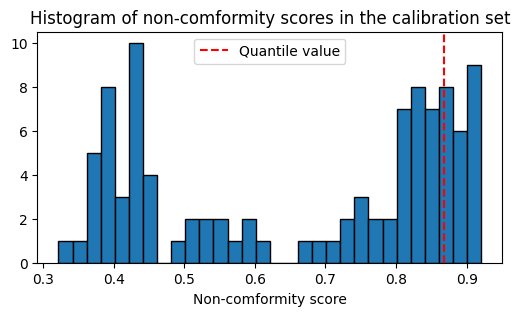


A good predictor should have low non-comformity scores, concentrated at the left side of the figure


In [25]:
#@markdown Find $\widehat{q}$ as the $\frac{\lceil (N+1)(1-\epsilon) \rceil}{N}$ quantile of the non-conformity scores, where $N$ is number of calibration data. Also plot the histogram of the scores and the quantile.
num_calibration_data = 100
q_level = np.ceil((num_calibration_data + 1) * (1 - epsilon)) / num_calibration_data
qhat = np.quantile(non_conformity_score, q_level, method='higher')
print('Quantile value qhat:', qhat)
print('')

# plot histogram and quantile
plt.figure(figsize=(6, 3))
plt.hist(non_conformity_score, bins=30, edgecolor='k', linewidth=1)
plt.axvline(
    x=qhat, linestyle='--', color='r', label='Quantile value'
)
plt.title(
    'Histogram of non-comformity scores in the calibration set'
)
plt.xlabel('Non-comformity score')
plt.legend(); plt.show()
print('')
print('A good predictor should have low non-comformity scores, concentrated at the left side of the figure')

============== Summary ==============
Number of calibration data: 100
Number of test data: 200
Average prediction set size: 2.24
Marginal coverage guarantee: 0.8
Empirical coverage: 0.79
Help rate: 0.85
Success rate: 0.79

Success rate should be the same as empirical coverage, and it is close to the marginal coverage guarantee, 1-epsilon



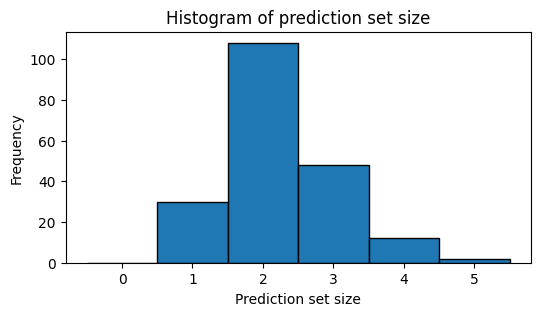

In [27]:
num_test_data = 200

num_coverage = 0
num_help = 0
num_success = 0
set_size_all = []
for data in test_set:
  top_logprobs = data['top_logprobs']
  top_tokens = data['top_tokens']
  true_options = data['true_options']

  # normalize the five scores to sum of 1
  mc_smx_all = temperature_scaling(top_logprobs, temperature=5)

  # include all options with score >= 1-qhat
  prediction_set = [
            token for token_ind, token in enumerate(top_tokens)
            if mc_smx_all[token_ind] >= 1 - qhat
        ]
  set_size_all.append(len(prediction_set))

  # check coverage
  flag_coverage = not set(prediction_set).isdisjoint(true_options)
  num_coverage += flag_coverage

  # check help - if prediction set is not singleton, or set include option E
  flag_help = len(prediction_set) != 1 or data['add_mc_prefix'] in prediction_set
  num_help += flag_help

  # check success - same as coverage
  num_success += flag_coverage

# get average rate
coverage_rate = num_coverage / num_test_data
help_rate = num_help / num_test_data
success_rate = num_success / num_test_data
avg_prediction_set_size = np.mean(set_size_all)

# show results
print('============== Summary ==============')
print('Number of calibration data:', num_calibration_data)
print('Number of test data:', num_test_data)
# print('Quantile value:', qhat)
print('Average prediction set size:', avg_prediction_set_size)
print('Marginal coverage guarantee:', 1 - epsilon)
print('Empirical coverage:', coverage_rate)
print('Help rate:', help_rate)
print('Success rate:', success_rate)
print('\nSuccess rate should be the same as empirical coverage, and it is close to the marginal coverage guarantee, 1-epsilon\n')

# plot histogram of prediction set size
plt.figure(figsize=(6, 3))
plt.hist(
    set_size_all, bins=np.arange(-1, 6) + 0.5, edgecolor='k',
    linewidth=1
)
ax = plt.gca()
ax.locator_params(integer=True)
plt.title('Histogram of prediction set size')
plt.xlabel('Prediction set size')
plt.ylabel('Frequency')
plt.show()

In [16]:
def test(instruction, scene_objects):  
    # prompt for generating multiple choice
   # instruction = "Put the bottled water in the bin." #@param {type:"string"}
   # scene_objects = "energy bar, bottled water, rice chips" #@param {type:"string"}

    demo_mc_gen_prompt = """
    We: You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a bottom one. There is also a landfill bin, a recycling bin, and a compost bin.

    We: On the counter, there is an orange soda, a Pepsi, and an apple.
    We: Put that drink in the top drawer.
    You:
    A) open the top drawer and put the orange soda in it
    B) open the bottom drawer and put the Pepsi in it
    C) open the bottom drawer and put the orange soda in it
    D) open the top drawer and put the Pepsi in it

    We: On the counter, there is an energy bar, a banana, and a microwave.
    We: Put the snack next to the microwave.
    You:
    A) pick up the energy bar and put it next to the microwave
    B) pick up the banana and put it next to the energy bar
    C) pick up the banana and put it next to the microwave
    D) pick up the energy bar and put it next to the banana

    We: On the counter, there is a Coke, a Sprite, and a sponge.
    We: Can you dispose of the can? It should have expired.
    You:
    A) pick up the sponge and put it in the landfill bin
    B) pick up the Coke and put it in the recycling bin
    C) pick up the Sprite and put it in the recycling bin
    D) pick up the Coke and put it in the landfill bin

    We: On the counter, there is a bottled water, a bag of jalapeno chips, and a bag of rice chips.
    We: I would like a bag of chips.
    You:
    A) pick up the bottled water
    B) pick up the jalapeno chips
    C) pick up the kettle chips
    D) pick up the rice chips

    We: On the counter, there is {scene_objects}
    We: {task}
    You:
    """
    demo_mc_gen_prompt = demo_mc_gen_prompt.replace('{task}', instruction)
    demo_mc_gen_prompt = demo_mc_gen_prompt.replace('{scene_objects}', scene_objects)

    # Generate multiple choices
    _, demo_mc_gen_raw = lm(demo_mc_gen_prompt, stop_seq=['We:'], logit_bias={})
    demo_mc_gen_raw = demo_mc_gen_raw.strip()
    demo_mc_gen_full, demo_mc_gen_all, demo_add_mc_prefix = process_mc_raw(demo_mc_gen_raw)

    # get the part of the current scenario from the previous prompt
    demo_cur_scenario_prompt = demo_mc_gen_prompt.split('\n\n')[-1].strip()

    # get new prompt
    demo_mc_score_background_prompt = """
    You are a robot operating in an office kitchen. You are in front of a counter with two closed drawers, a top one and a middle one. There is also a landfill bin, a recycling bin, and a compost bin.
    """.strip()
    demo_mc_score_prompt = demo_mc_score_background_prompt + '\n\n' + demo_cur_scenario_prompt + '\n' + demo_mc_gen_full
    demo_mc_score_prompt += "\nWe: Which option is correct? Answer with a single capital letter."
    demo_mc_score_prompt += "\nYou:"

    # scoring
    mc_score_response, _ = lm(demo_mc_score_prompt, max_tokens=1, logprobs=5)
    top_logprobs_full = mc_score_response["choices"][0]["logprobs"]["top_logprobs"][0]
    top_tokens = [token.strip() for token in top_logprobs_full.keys()]
    top_logprobs = [value for value in top_logprobs_full.values()]

    # get prediction set
    def temperature_scaling(logits, temperature):
        logits = np.array(logits)
        logits /= temperature

        # apply softmax
        logits -= logits.max()
        logits = logits - np.log(np.sum(np.exp(logits)))
        smx = np.exp(logits)
        return smx
    mc_smx_all = temperature_scaling(top_logprobs, temperature=5)

    # include all options with score >= 1-qhat
    prediction_set = [
              token for token_ind, token in enumerate(top_tokens)
              if mc_smx_all[token_ind] >= 1 - qhat
          ]

    # print
    #print('Multiple choices generated:')
    #print(demo_mc_gen_full)
    #print('\nPrediction set:', prediction_set)
    if len(prediction_set) == 1:
      hr = 0
      #print('No help needed!')
    else:
      hr = 1
      #print('Help needed!')

    return prediction_set, hr

In [ ]:
skip_calibration = False #@param {type:"boolean"}
if skip_calibration: qhat = 0.928 # based on epsilon=0.2

import random
def process_mc_raw(mc_raw, add_mc='an option not listed here'):
  mc_all = mc_raw.split('\n')
  mc_processed_all = []
  for mc in mc_all:
      mc = mc.strip()  # sometimes there is leading space
      # skip nonsense
      if len(mc) < 5 or mc[0] not in [
          'a', 'b', 'c', 'd', 'A', 'B', 'C', 'D', '1', '2', '3', '4'
      ]:
          continue
      mc = mc[2:]  # remove a), b), ...
      mc = mc.strip().lower().split('.')[0]
      mc_processed_all.append(mc)
  if len(mc_processed_all) < 4:
      raise 'Cannot extract four options from the raw output.'
  # Check if any repeated option - use do nothing as substitue
  mc_processed_all = list(set(mc_processed_all))
  if len(mc_processed_all) < 4:
      num_need = 4 - len(mc_processed_all)
      for _ in range(num_need):
          mc_processed_all.append('do nothing')
  prefix_all = ['A) ', 'B) ', 'C) ', 'D) ']
  if add_mc is not None:
      mc_processed_all.append(add_mc)
      prefix_all.append('E) ')
  random.shuffle(mc_processed_all)
  mc_prompt = ''
  for mc_ind, (prefix, mc) in enumerate(zip(prefix_all, mc_processed_all)):
      mc_prompt += prefix + mc
      if mc_ind < len(mc_processed_all) - 1:
          mc_prompt += '\n'
  add_mc_prefix = prefix_all[mc_processed_all.index(add_mc)][0]
  return mc_prompt, mc_processed_all, add_mc_prefix

In [17]:
prediction_sets = []
hrs = []
tasks = []
for i in range(len(test_data)):
    infos = test_data['info'].split()
    instruction = infos[1][6:]
    tasks.append(instruction)
    scene_objects = infos[0][7:]
    prediction_set, hr = test(instruction, scene_objects)
    prediction_sets.append(prediction_set)
    hrs.append(hr)

NameError: name 'test_data' is not defined